### To-Do
Avg. CV IKI by word type (WF and BF)  
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  

In [1]:
import numpy as np
import pandas as pd
import ast
import math
import glob
import matplotlib.pyplot as plt
from scipy.stats import variation
import warnings
from statsmodels.stats.anova import AnovaRM
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import typingmod as typ

## Dataframe Setup

In [2]:
np.seterr(invalid='ignore') ## gets rid of runtime error about invalid division

ID_list = ['s83', 's20', 's179', 's178', 's175', 'p09', 'p10', 'p11']

In [3]:
## making one trial based dataframe using data from all participants
all_maindfs = glob.glob("subject_data/main_dfs/*.csv")
all_trials = (pd.concat((pd.read_csv(f) for f in all_maindfs))).reset_index(drop=True)

## making dataframe of only rts from all trials
all_rts = typ.rt_columns(all_trials)

## adding ikis to main dataframe using all_rts
all_trials = pd.concat([all_trials, typ.iki(all_rts).iloc[:,1:7]], axis = 1)
all_trials = all_trials.rename(columns={0: 'iki_1', 1: 'iki_2', 2: 'iki_3', 3: 'iki_4', 4: 'iki_5', 5: 'iki_6'})
all_trials = all_trials.drop(columns=['Unnamed: 0'])

## making one trial based dataframe using data from all participants
all_bigramdfs = glob.glob("subject_data/bigram_dfs/*.csv")
all_bigrams = (pd.concat((pd.read_csv(f) for f in all_bigramdfs))).reset_index(drop=True)
all_bigrams['Bigram'] = all_bigrams['Bigram'].apply(lambda x: (x.replace("'", "")).replace(" ", ""))
all_bigrams = all_bigrams.rename(columns = {'Trial #': 'trial', 'Bigram #': 'bigram_num'})
all_bigrams = all_bigrams.drop(columns=['Unnamed: 0'])

## making filtered dataframes
corr_trials = (all_trials[all_trials.string == all_trials.resp_string]).reset_index(drop=True)
incorr_trials = (all_trials[all_trials.string != all_trials.resp_string]).reset_index(drop=True)

corr_bgs = typ.correct_filter(all_bigrams) ## only correct trials
incorr_bgs = typ.incorrect_filter(all_bigrams) ## only incorrect trials

corr_rts = typ.rt_columns(corr_trials) ## only correct rts
incorr_rts = typ.rt_columns(incorr_trials) ## only incorrect rts

## making filtered dataframes by word frequency
highwf_df = all_trials[all_trials['string'].isin(typ.highwf)]
medwf_df = all_trials[all_trials['string'].isin(typ.medwf)]
lowwf_df = all_trials[all_trials['string'].isin(typ.lowwf)]
pseudo_df = all_trials[all_trials['string'].isin(typ.pseudo)]

## making filtered dataframes by bigram frequency
highbf_df = all_trials[all_trials['string'].isin(typ.highbf)]
medbf_df = all_trials[all_trials['string'].isin(typ.medbf)]
lowbf_df = all_trials[all_trials['string'].isin(typ.lowbf)]

## making dataframes with rts by word frequency type
highwf_rts = (typ.rt_columns(highwf_df)).reset_index(drop=True)
medwf_rts = (typ.rt_columns(medwf_df)).reset_index(drop=True)
lowwf_rts = (typ.rt_columns(lowwf_df)).reset_index(drop=True)
pseudo_rts = (typ.rt_columns(pseudo_df)).reset_index(drop=True)

## making dataframes with rts by bigram frequency type
highbf_rts = (typ.rt_columns(highbf_df)).reset_index(drop=True)
medbf_rts = (typ.rt_columns(medbf_df)).reset_index(drop=True)
lowbf_rts = (typ.rt_columns(lowbf_df)).reset_index(drop=True)

## making dataframe with only correct trials that have ikis within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.iloc[:, 24:28]: ## depends on position of iki columns
        avg_iki = sub_df[col].mean()
        sd_iki = sub_df[col].std()
        sub_df = sub_df.loc[(sub_df[col] < (avg_iki + 2*sd_iki)) & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])
    
## making dataframe with only correct bigrams that have ikis within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_bgs[corr_bgs.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])

In [4]:
all_bigrams

sID  bigram_num  trial Bigram       IKI string resp_string  rep #
0     p09           0      0     th  0.031989  think       think      0
1     p09           1      0     hi  0.176052  think       think      0
2     p09           2      0     in  0.183951  think       think      0
3     p09           3      0     nk  0.423997  think       think      0
4     p09           4      1     bu  0.343929  buddy       buddy      0
...   ...         ...    ...    ...       ...    ...         ...    ...
7722  s20         955    238     rm  0.119958  therm       therm      9
7723  s20         956    239     he  0.111920  heond       heond      9
7724  s20         957    239     eo  0.207952  heond       heond      9
7725  s20         958    239     on  0.232084  heond       heond      9
7726  s20         959    239     nd  0.167909  heond       heond      9

[7727 rows x 8 columns]

## Variables by Word and Word Type (WF and BF)

In [5]:
plt.rcParams['font.size'] = '30'

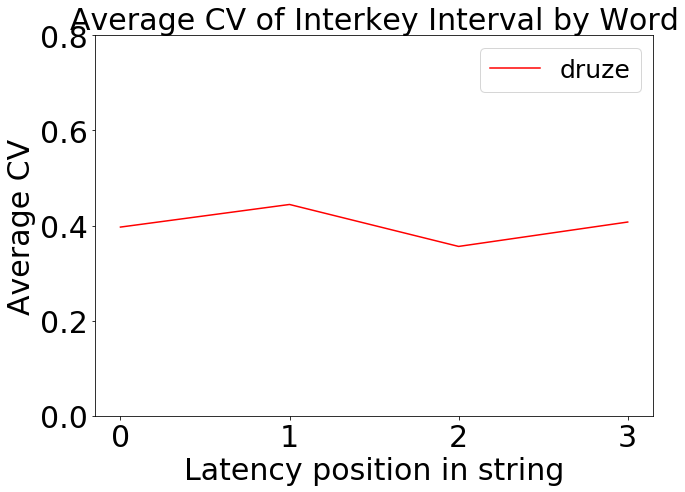

In [6]:
## creating dataframe from 'cv_byword' function that is easy to plot
cv_word = 'druze' # change this for which ever word you want to plot
cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

## plotting digraph latency variations by word (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

## Set general font size
plt.rcParams['font.size'] = '25'

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by Word")
plt.legend(loc="best")

plt.show()

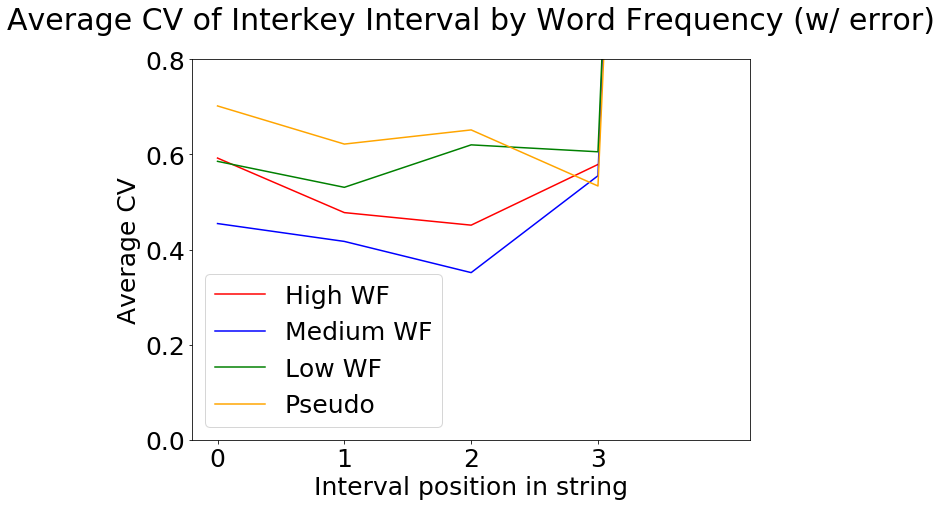

In [7]:
## plotting digraph latency variations by WF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

## Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(25)

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Interval position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
plt.legend(loc="best")

# plt.savefig('ian_iki.png')

plt.show()

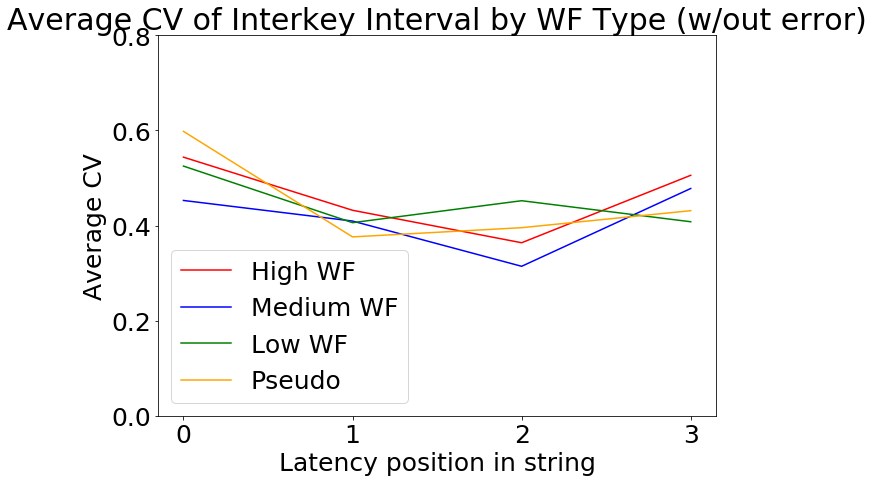

In [8]:
## plotting digraph latency variations by WF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by WF Type (w/out error)")
plt.legend(loc="best")

plt.show()

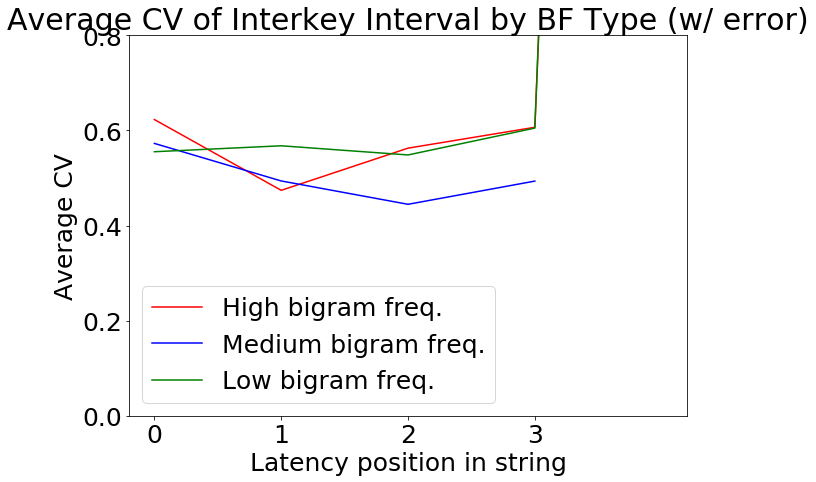

In [9]:
## plotting digraph latency variations by BF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.highbf, all_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.medbf, all_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.lowbf, all_rts), color='green', label='Low bigram freq.')

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by BF Type (w/ error)")
plt.legend(loc="best")

plt.show()

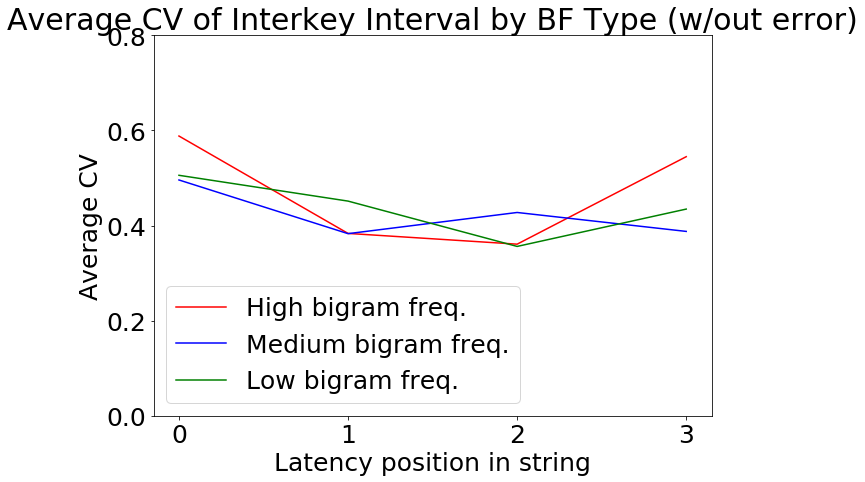

In [10]:
## plotting digraph latency variations by BF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.highbf, corr_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.medbf, corr_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.lowbf, corr_rts), color='green', label='Low bigram freq.')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by BF Type (w/out error)")
plt.legend(loc="best")

plt.show()

In [11]:
# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('IKI Distribution by WF', y=0.95)

# axs[0, 0].boxplot((typ.iki(highwf_rts)).loc[:, 0:3])
# axs[0, 0].set_title("High WF")
# # axs[0, 0].set_median(linewidth = 3)
# # axs[0, 0].set_ylim([-0.01, 1])
# axs[0, 1].boxplot((typ.iki(medwf_rts)).loc[:, 0:3])
# axs[0, 1].set_title("Med WF")
# # axs[0, 1].set_ylim([-0.01, 1])
# axs[1, 0].boxplot((typ.iki(lowwf_rts)).loc[:, 0:3])
# axs[1, 0].set_title("Low WF")
# # axs[1, 0].set_ylim([-0.01, 1])
# axs[1, 1].boxplot((typ.iki(pseudo_rts)).loc[:, 0:3])
# axs[1, 1].set_title("Pseudo")
# # axs[1, 1].set_ylim([-0.01, 1])

# for ax in axs.flat:
#     ax.set(ylabel='IKI (s)', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [12]:
highwf_ikis = pd.concat([typ.iki(highwf_rts)[0], typ.iki(highwf_rts)[1], typ.iki(highwf_rts)[2], typ.iki(highwf_rts)[3]], axis=0, ignore_index=True)
medwf_ikis = pd.concat([typ.iki(medwf_rts)[0], typ.iki(medwf_rts)[1], typ.iki(medwf_rts)[2], typ.iki(medwf_rts)[3]], axis=0, ignore_index=True)
lowwf_ikis = pd.concat([typ.iki(lowwf_rts)[0], typ.iki(lowwf_rts)[1], typ.iki(lowwf_rts)[2], typ.iki(lowwf_rts)[3]], axis=0, ignore_index=True)
pseudo_ikis = pd.concat([typ.iki(pseudo_rts)[0], typ.iki(pseudo_rts)[1], typ.iki(pseudo_rts)[2], typ.iki(pseudo_rts)[3]], axis=0, ignore_index=True)

highbf_ikis = pd.concat([typ.iki(highbf_rts)[0], typ.iki(highbf_rts)[1], typ.iki(highbf_rts)[2], typ.iki(highbf_rts)[3]], axis=0, ignore_index=True)
medbf_ikis = pd.concat([typ.iki(medbf_rts)[0], typ.iki(medbf_rts)[1], typ.iki(medbf_rts)[2], typ.iki(medbf_rts)[3]], axis=0, ignore_index=True)
lowbf_ikis = pd.concat([typ.iki(lowbf_rts)[0], typ.iki(lowbf_rts)[1], typ.iki(lowbf_rts)[2], typ.iki(lowbf_rts)[3]], axis=0, ignore_index=True)

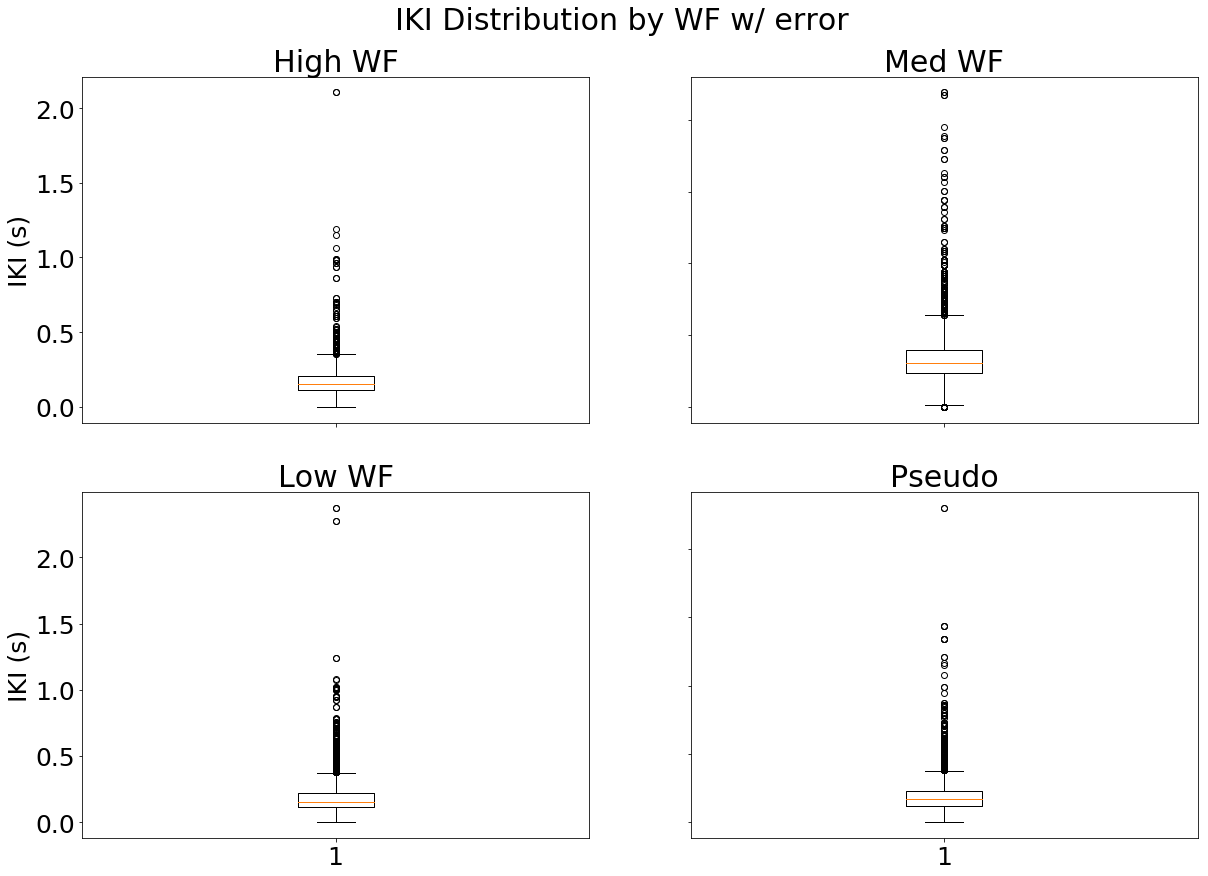

In [13]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('IKI Distribution by WF w/ error', y=0.95)

axs[0, 0].boxplot(highwf_ikis)
axs[0, 0].set_title("High WF")
# axs[0, 0].set_median(linewidth = 3)
# axs[0, 0].set_ylim([-0.01, 1])
axs[0, 1].boxplot(medwf_ikis)
axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1])
axs[1, 0].boxplot(lowwf_ikis)
axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1])
axs[1, 1].boxplot(pseudo_ikis)
axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1])

for ax in axs.flat:
    ax.set(ylabel='IKI (s)', xlabel='')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

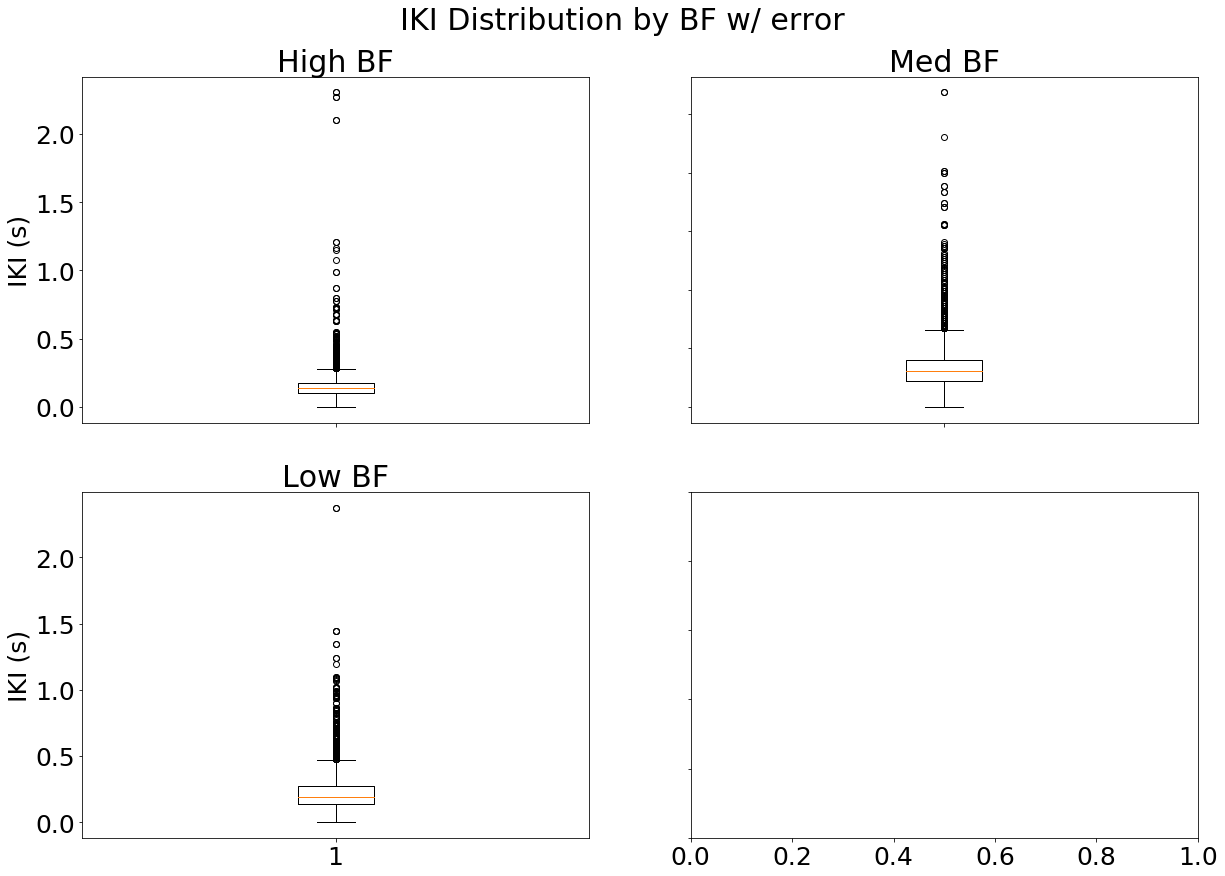

In [14]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('IKI Distribution by BF w/ error', y=0.95)

axs[0, 0].boxplot(highbf_ikis)
axs[0, 0].set_title("High BF")
# axs[0, 0].set_median(linewidth = 3)
# axs[0, 0].set_ylim([-0.01, 1])
axs[0, 1].boxplot(medbf_ikis)
axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1])
axs[1, 0].boxplot(lowbf_ikis)
axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1])

for ax in axs.flat:
    ax.set(ylabel='IKI (s)', xlabel='')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

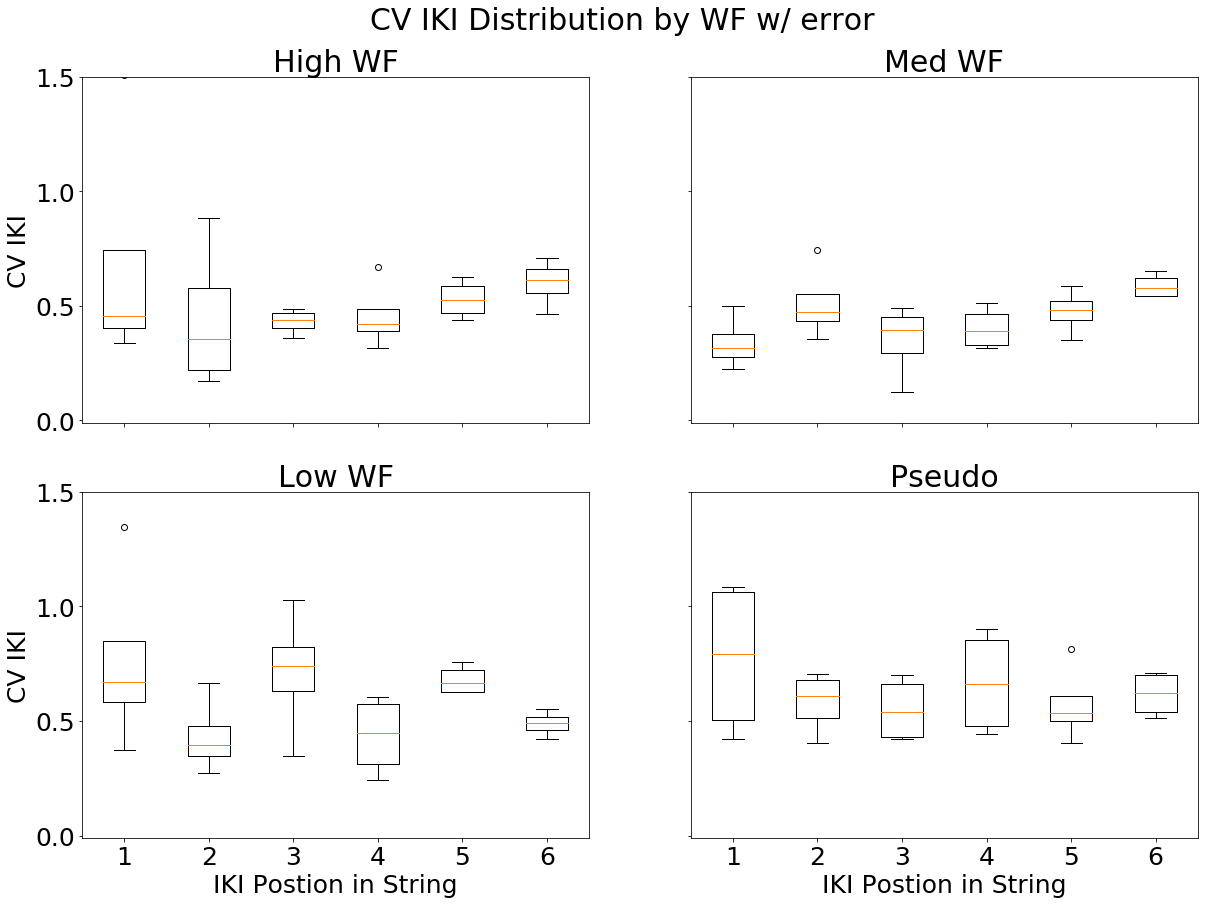

In [15]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
axs[0, 0].set_title("High WF")
axs[0, 0].set_ylim([-0.01, 1.5])
axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
axs[0, 1].set_title("Med WF")
axs[0, 1].set_ylim([-0.01, 1.5])
axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
axs[1, 0].set_title("Low WF")
axs[1, 0].set_ylim([-0.01, 1.5])
axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
axs[1, 1].set_title("Pseudo")
axs[1, 1].set_ylim([-0.01, 1.5])

for ax in axs.flat:
    ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

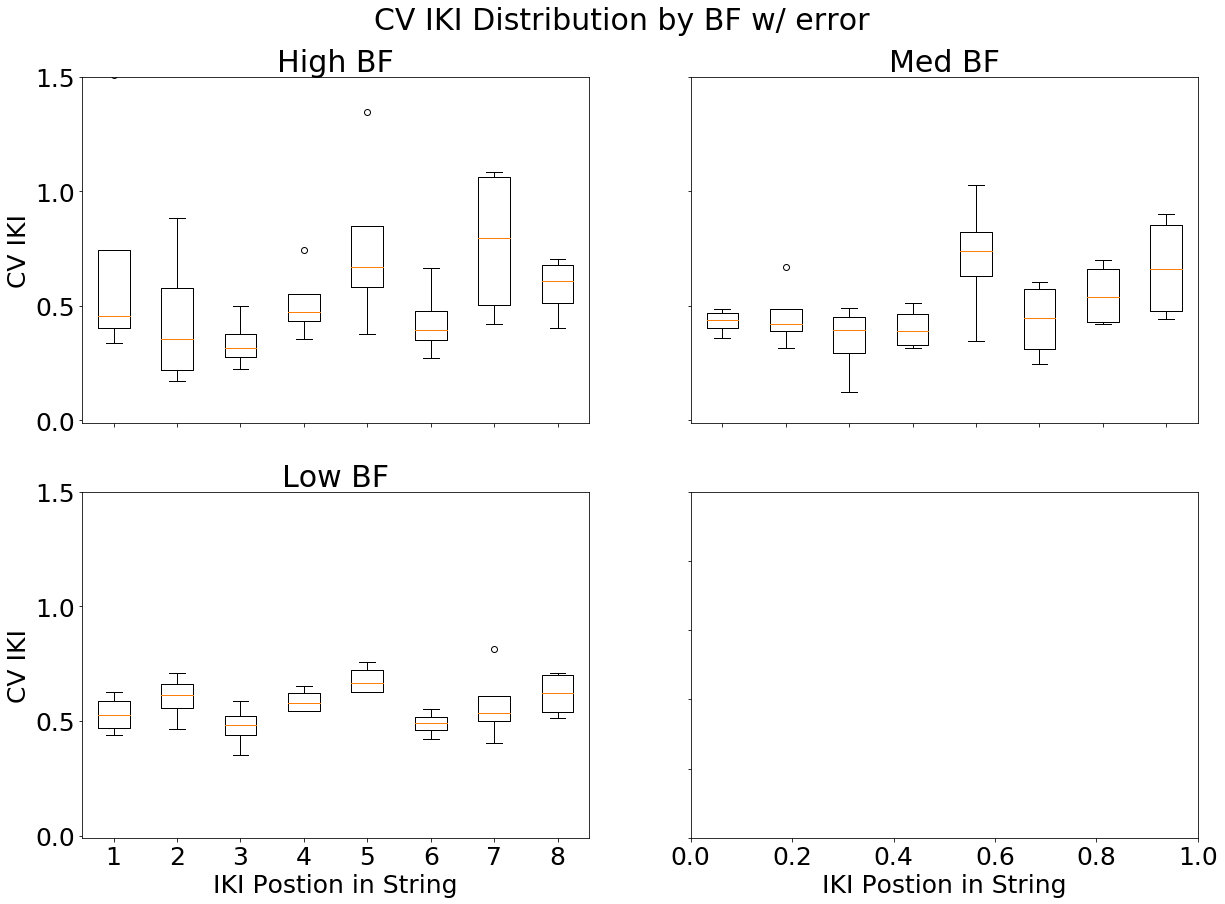

In [16]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('CV IKI Distribution by BF w/ error', y=0.95)

axs[0, 0].boxplot((typ.cv_all(typ.highbf, all_rts).loc[:, 1:4]))
axs[0, 0].set_title("High BF")
axs[0, 0].set_ylim([-0.01, 1.5])
axs[0, 1].boxplot((typ.cv_all(typ.medbf, all_rts).loc[:, 1:4]))
axs[0, 1].set_title("Med BF")
axs[0, 1].set_ylim([-0.01, 1.5])
axs[1, 0].boxplot((typ.cv_all(typ.lowbf, all_rts).loc[:, 1:4]))
axs[1, 0].set_title("Low BF")
axs[1, 0].set_ylim([-0.01, 1.5])

for ax in axs.flat:
    ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [17]:
## defining function for finding CV IKI avg for each individual
def avgcv_bysub(word_type, DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        sub_avg = typ.avg_cv(word_type, sub_data)
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg CV 1', 'Avg CV 2', 'Avg CV 3', 'Avg CV 4'])
    return sub_avgs

## defining function for finding Avg IKI for each individual
def avgposiki_bysub(DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        ikis = typ.iki(sub_data)
        sub_avg = []
        ikis.iloc[:, 1:5].mean()
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI 1', 'Avg IKI 2', 'Avg IKI 3', 'Avg IKI 4'])
    return sub_avgs

def avgiki_bysub(DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        ikis = typ.iki(sub_data)
        iki_list = pd.concat([ikis[1], ikis[2], ikis[3], ikis[4]], ignore_index=True)
        sub_avg = []
        sub_avg.append(np.mean(iki_list))
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI'])
    return sub_avgs

# def avgiki_bysub_bg(DF):
#     sub_avgs =[]
#     for sub in ID_list:
#         sub_data = pd.DataFrame()
#         for index, data in DF.iterrows():
#             if DF.loc[index, 'sID'] == sub:
#                 sub_data = sub_data.append(DF.loc[index], ignore_index=True)
#         sub_avg = []
#         sub_avg.append(np.mean(sub_data['IKI']))
#         sub_avg.insert(0, sub)
#         sub_avgs.append(sub_avg)
#     sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI'])
#     return sub_avgs

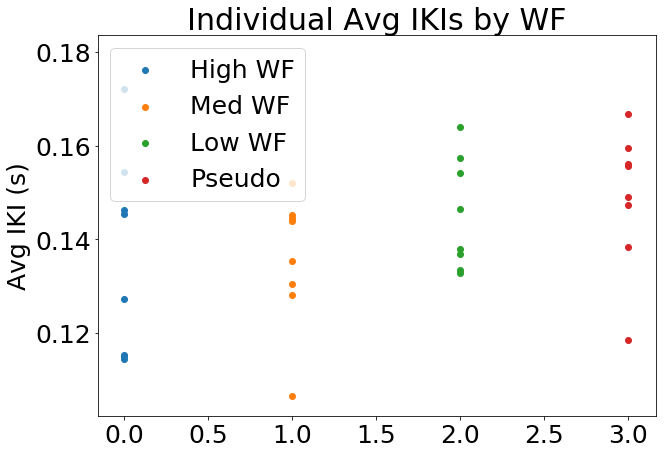

In [18]:
plt.figure(figsize=(10, 7))
highwf_scatter = plt.scatter(([0] * len((avgiki_bysub(highwf_rts)).iloc[:, 1])), avgiki_bysub(highwf_rts).iloc[:, 1], label='High WF')
medwf_scatter = plt.scatter(([1] * len((avgiki_bysub(medwf_rts)).iloc[:, 1])), avgiki_bysub(medwf_rts).iloc[:, 1], label='Med WF')
lowwf_scatter = plt.scatter(([2] * len((avgiki_bysub(lowwf_rts)).iloc[:, 1])), avgiki_bysub(lowwf_rts).iloc[:, 1], label='Low WF')
pseudo_scatter = plt.scatter(([3] * len((avgiki_bysub(pseudo_rts)).iloc[:, 1])), avgiki_bysub(pseudo_rts).iloc[:, 1], label='Pseudo')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by WF")
plt.legend(loc= "best")

plt.show()

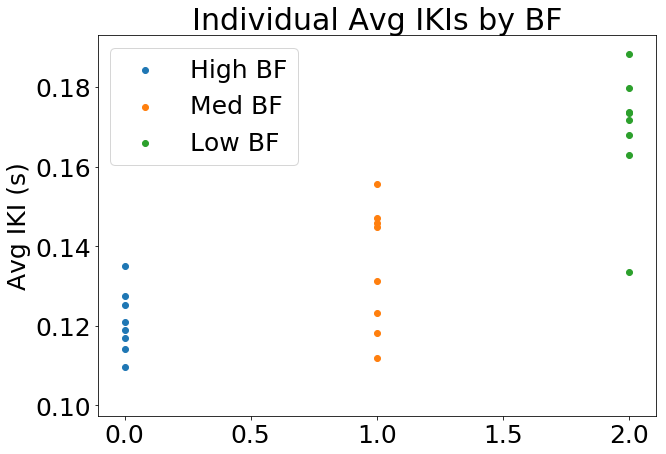

In [19]:
plt.figure(figsize=(10, 7))
highbf_scatter = plt.scatter(([0] * len((avgiki_bysub(highbf_rts)).iloc[:, 1])), avgiki_bysub(highbf_rts).iloc[:, 1], label='High BF')
medbf_scatter = plt.scatter(([1] * len((avgiki_bysub(medbf_rts)).iloc[:, 1])), avgiki_bysub(medbf_rts).iloc[:, 1], label='Med BF')
lowbf_scatter = plt.scatter(([2] * len((avgiki_bysub(lowbf_rts)).iloc[:, 1])), avgiki_bysub(lowbf_rts).iloc[:, 1], label='Low BF')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by BF")
plt.legend(loc= "best")

plt.show()

In [20]:
bg_freqs = pd.read_csv('bg_freqs.csv').drop(labels=['Unnamed: 0'], axis=1)
bg_freqs = bg_freqs.sort_values(by='Frequency', ascending=False, ignore_index=True)
bg_freqs[0:60]

Bigrams  Frequency
0       th   22288309
1       he   21484684
2       in   13597302
3       er   12934901
4       an   12315713
5       re   10687711
6       nd    9414961
7       on    8830487
8       ed    7805967
9       ou    7425307
10      ha    6967591
11      it    6637233
12      hi    6198006
13      ti    5135552
14      le    5038239
15      me    4724108
16      ll    4235407
17      be    3798740
18      co    3609272
19      ch    3267507
20      ut    3257233
21      el    3235254
22      ee    2839722
23      ly    2589130
24      ul    2181271
25      ir    2142678
26      em    2039661
27      ld    2012500
28      oo    1933683
29      ol    1804856
30      wo    1723496
31      am    1610395
32      ab    1203849
33      bu    1183063
34      bo    1140702
35      fa    1043958
36      mp    1042198
37      od    1013147
38      up     968744
39      ck     925655
40      rm     905131
41      uc     891233
42      pp     805170
43      ru     705492
44      lu     568081
45      va     560130
46      pu     514720
47      ib     493267
48      ud     458716
49      nk     445067
50      vo     368238
51      dy     360103
52      dd     306083
53      eo     305120
54      oe     270012
55      py     149099
56      bj     105433
57      ka      60568
58      zi      54565
59      nr      54341

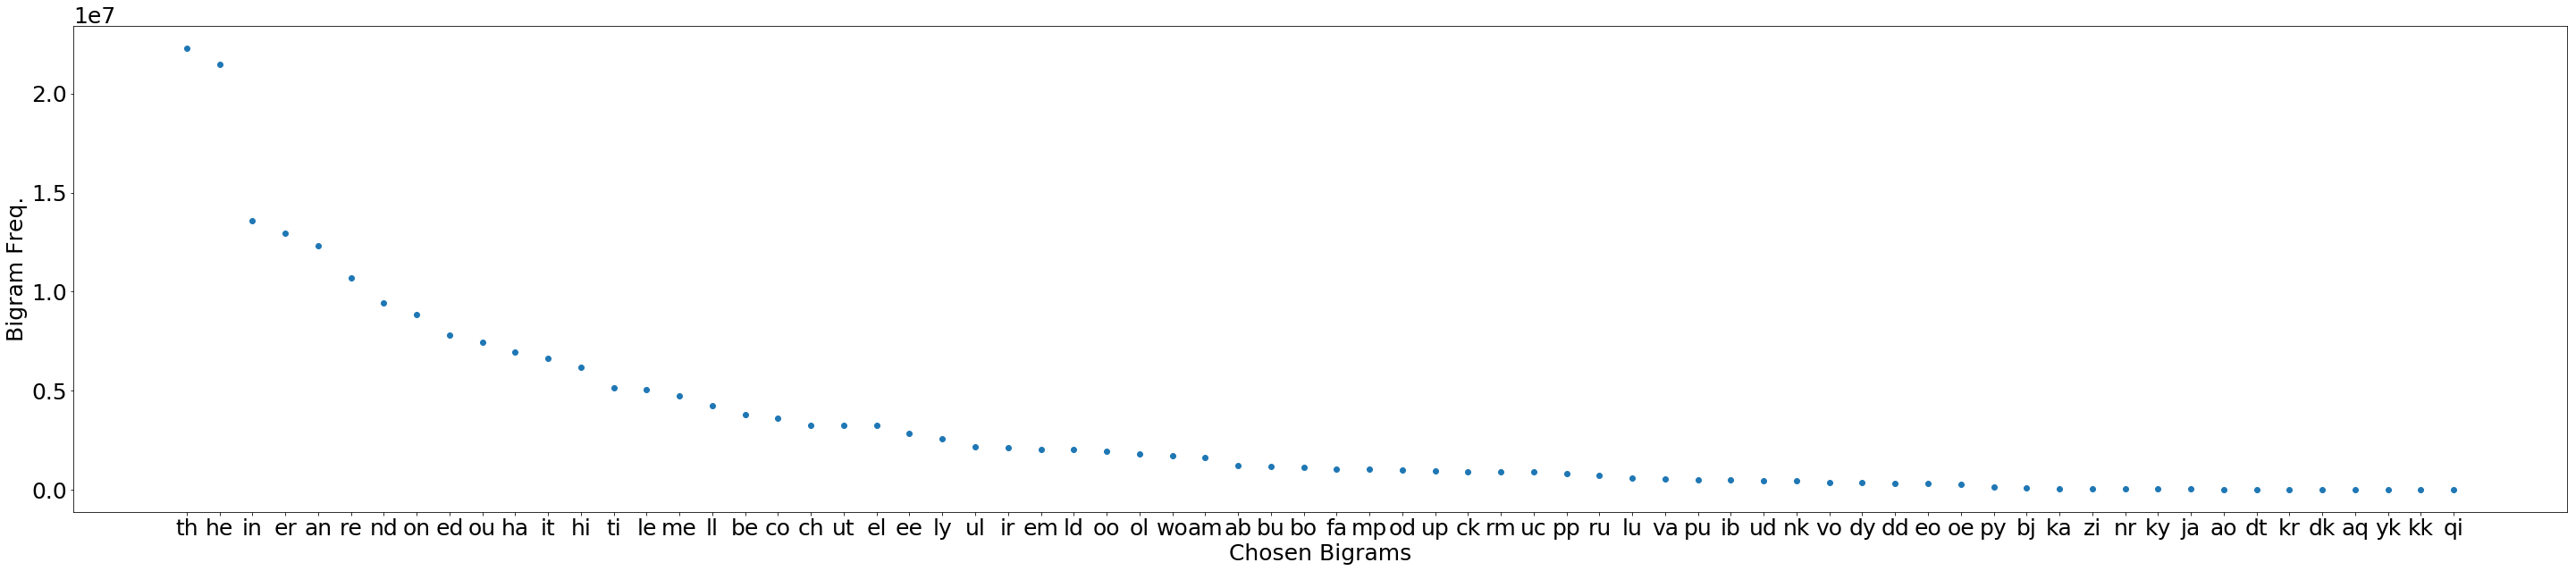

In [21]:
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(bg_freqs['Bigrams'], bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [22]:
high_bgs = bg_freqs.loc[0:15]
med_bgs = bg_freqs.loc[15:46]
low_bgs = bg_freqs.loc[46:69]

In [23]:
## defining function to organize bigram ikis
def bg_iki_sort(DF, sort_parameter): # DF is all_bgs or corr_bgs, sort_parameter is relevant list of strings
    bg_ikis = []
    bg_strings = []
    for bg in bg_freqs['Bigrams']:
        ikis = [bg]
        strings = [bg]
        for index, data in DF.iterrows():
            if ((DF['Bigram'][index]).replace("'", "")).replace(" ", "") == bg and DF['string'][index] in sort_parameter:
                ikis.append(DF['IKI'][index])
                strings.append(DF['string'][index])
        bg_ikis.append(ikis)
        bg_strings.append(strings)
            
    return pd.DataFrame(bg_ikis)
#     bg_strings = pd.DataFrame(bg_strings)

In [24]:
bg_ikis = []
bg_strings = []
for bg in bg_freqs['Bigrams']:
    ikis = [bg]
    strings = [bg]
    for index, data in corr_bgs.iterrows():
        if corr_bgs['Bigram'][index] == bg:
            ikis.append(corr_bgs['IKI'][index])
            strings.append(corr_bgs['string'][index])
    bg_ikis.append(ikis)
    bg_strings.append(strings)
    
            
bg_ikis = pd.DataFrame(bg_ikis)
bg_strings = pd.DataFrame(bg_strings)

bg_xvals = []
for n in range(0,70):
    bg_xvals.append([n]*577)
    
bg_xvals = pd.DataFrame(bg_xvals)

In [25]:
bg_stats = []
for index, data in bg_ikis.iterrows():
    bg_stats.append([bg_ikis.iloc[index, 0], bg_ikis.iloc[index, 1:577].mean(), np.std(bg_ikis.iloc[index, 1:577]), variation((bg_ikis.iloc[index, 1:577].tolist()), nan_policy='omit')])
    
bg_stats = pd.DataFrame(bg_stats, columns=['Bigram', 'Mean', 'STD', 'CV'])

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(bg_stats)

   Bigram      Mean       STD        CV
0      th  0.123901  0.076766  0.619573
1      he  0.139043  0.063043  0.453405
2      in  0.195186  0.030784  0.157717
3      er  0.137036  0.060639  0.442505
4      an  0.185230  0.077525  0.418532
5      re  0.151386  0.170345  1.125239
6      nd  0.145699  0.056662  0.388894
7      on  0.233394  0.096452  0.413258
8      ed  0.212898  0.183461  0.861732
9      ou  0.177279  0.076712  0.432718
10     ha  0.161481  0.100220  0.620634
11     it  0.133710  0.059343  0.443817
12     hi  0.189838  0.095087  0.500883
13     ti  0.144334  0.074436  0.515718
14     le  0.098530  0.032789  0.332785
15     me  0.123727  0.085997  0.695056
16     ll  0.153121  0.019165  0.125161
17     be  0.146857  0.064961  0.442341
18     co  0.206947  0.111757  0.540029
19     ch  0.138468  0.043152  0.311642
20     ut  0.114826  0.040368  0.351556
21     el  0.220311  0.077986  0.353980
22     ee  0.163628  0.041372  0.252838
23     ly  0.160625  0.077709  0.483791


In [26]:
def bgplot_bystr():
    for string in typ.all_strings:
        s = bg_strings[bg_strings.isin([string])].stack()
        L = s.index.tolist()
        xvals = []
        ikis = []
        for i in L:
            xvals.append(bg_xvals.iloc[i])
            ikis.append(bg_ikis.iloc[i])
    rbg = np.random.rand(3,).reshape(1,-1)
    plt.scatter(xvals, ikis, c=rbg)

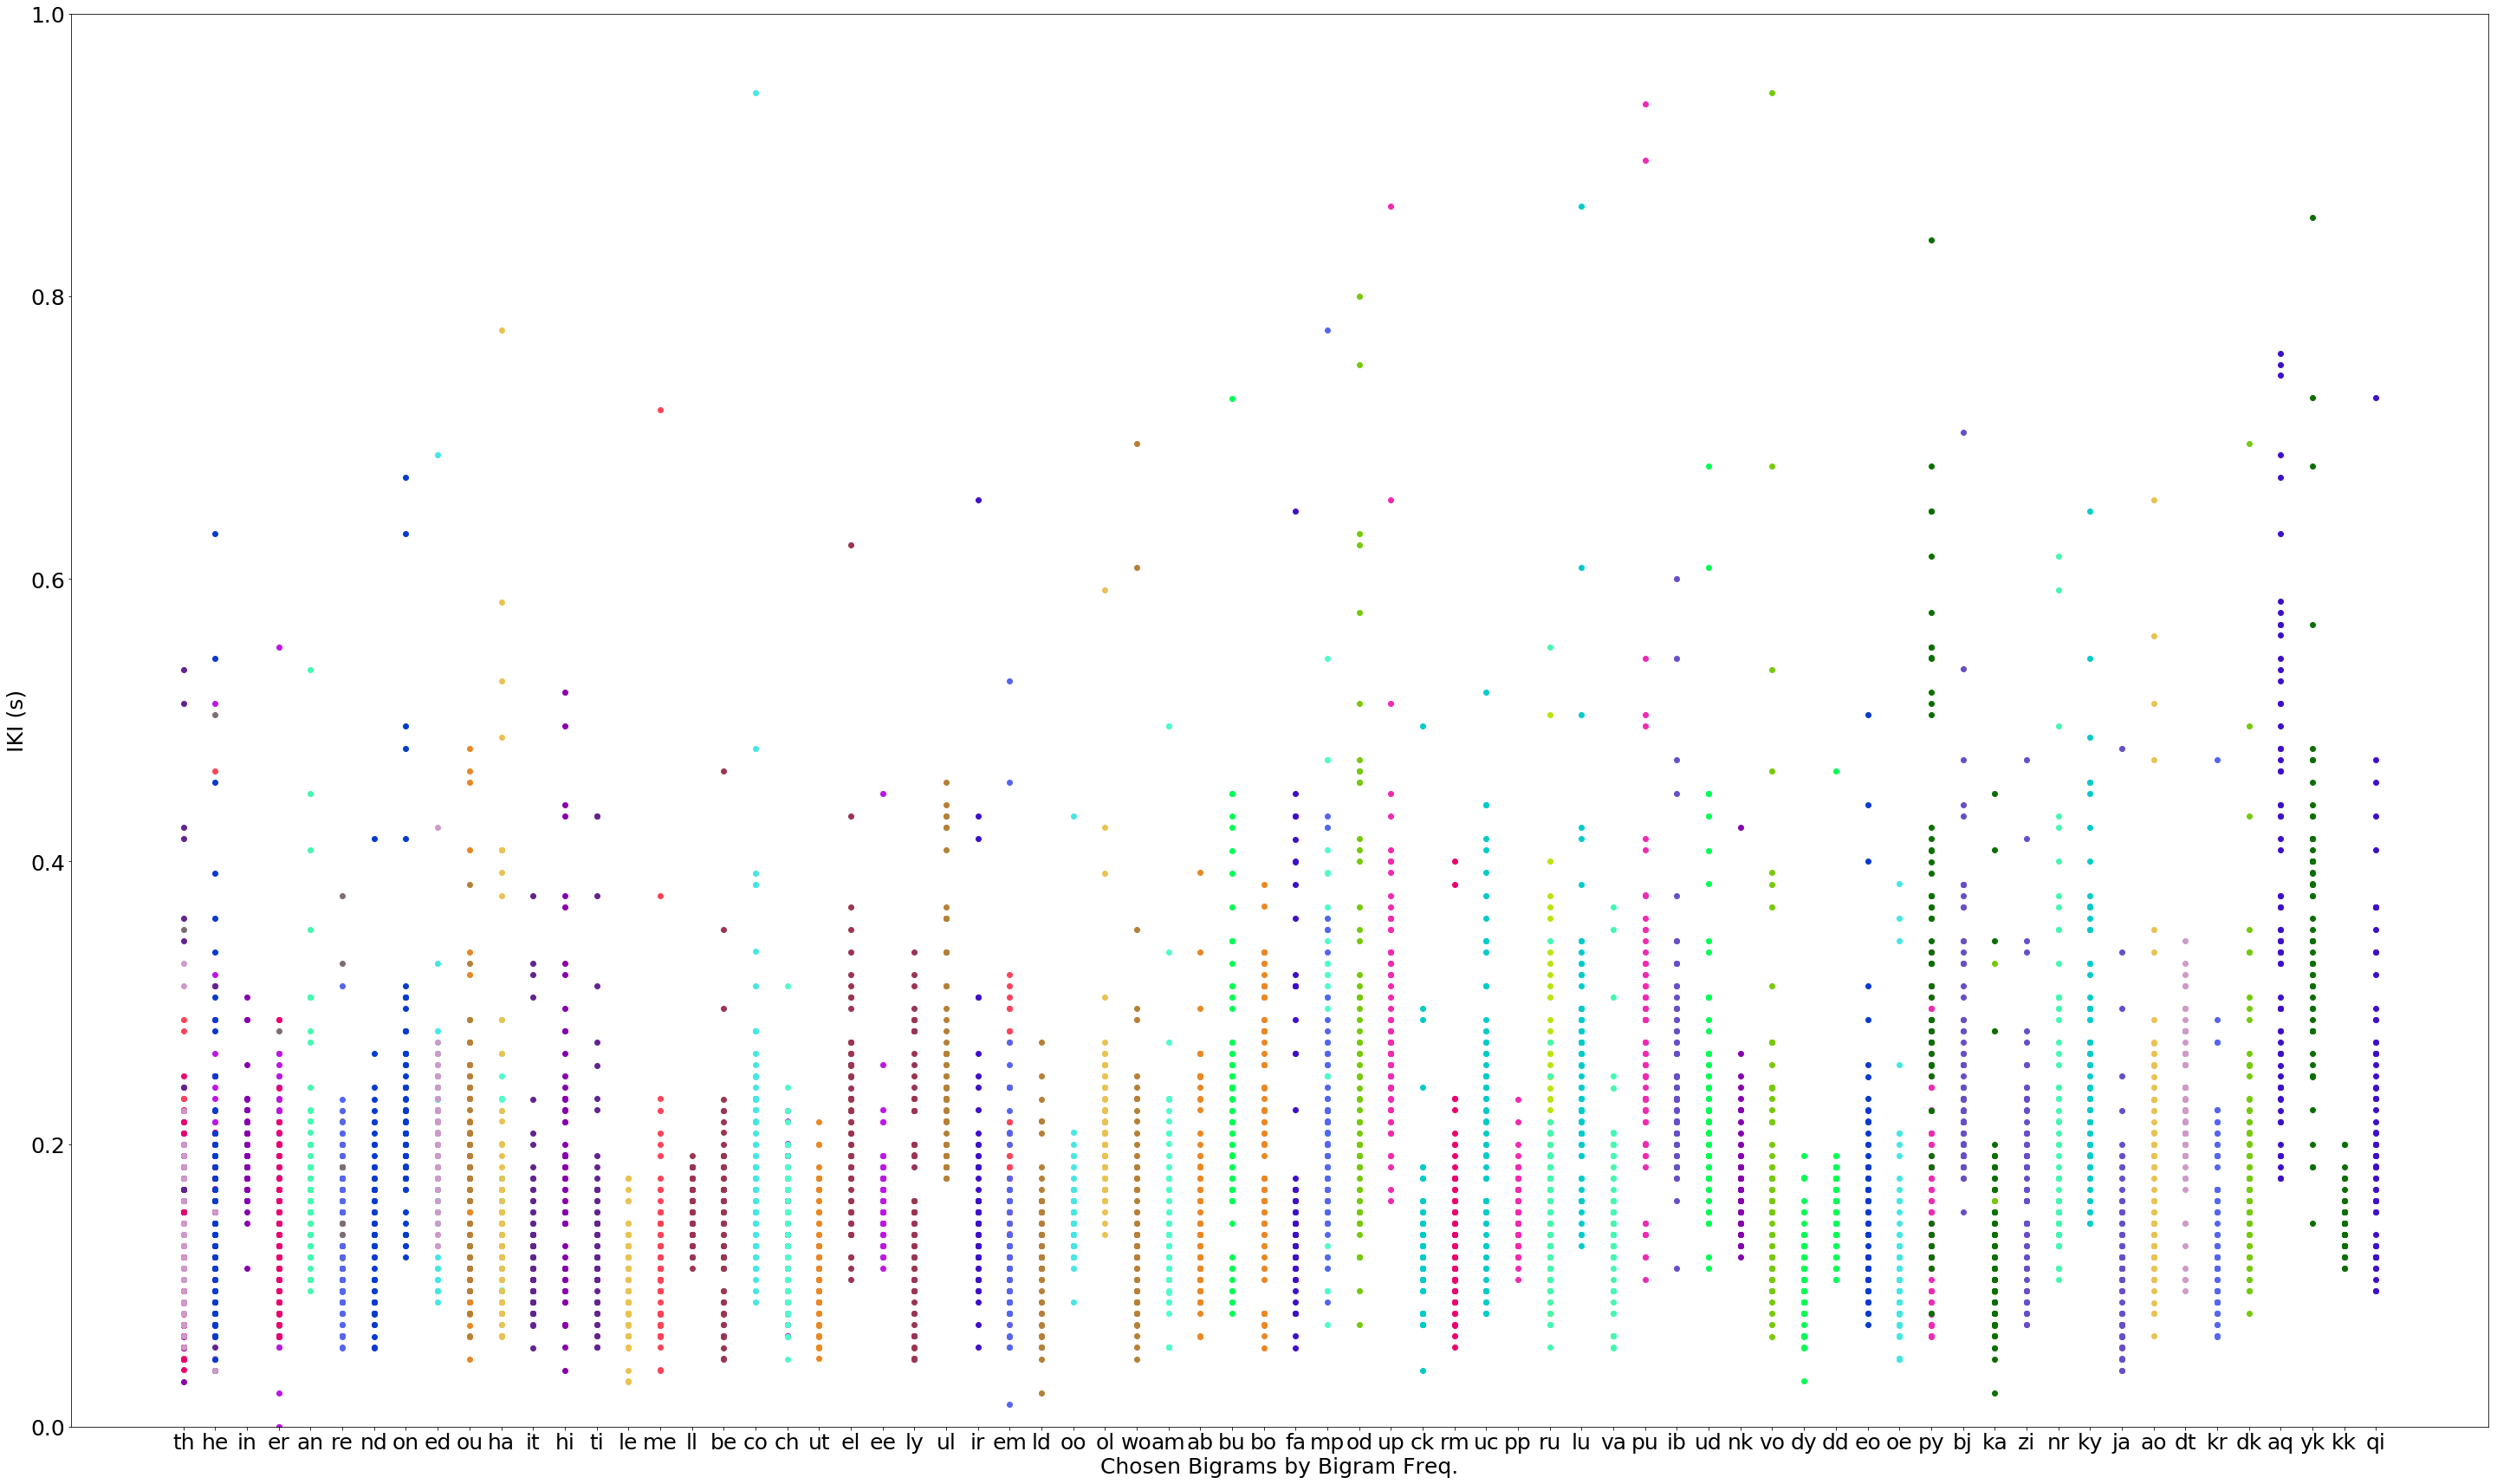

In [27]:
## scatter of iki values by bigram and word(color)
plt.figure(figsize=(50, 30))

for string in typ.all_strings:
    s = bg_strings[bg_strings.isin([string])].stack()
    L = s.index.tolist()
    xvals = []
    ikis = []
    for i in L:
        xvals.append(bg_xvals.iloc[i])
        ikis.append(bg_ikis.iloc[i])
    rbg = np.random.rand(3,).reshape(1,-1)
    plt.scatter(xvals, ikis, c=rbg)

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

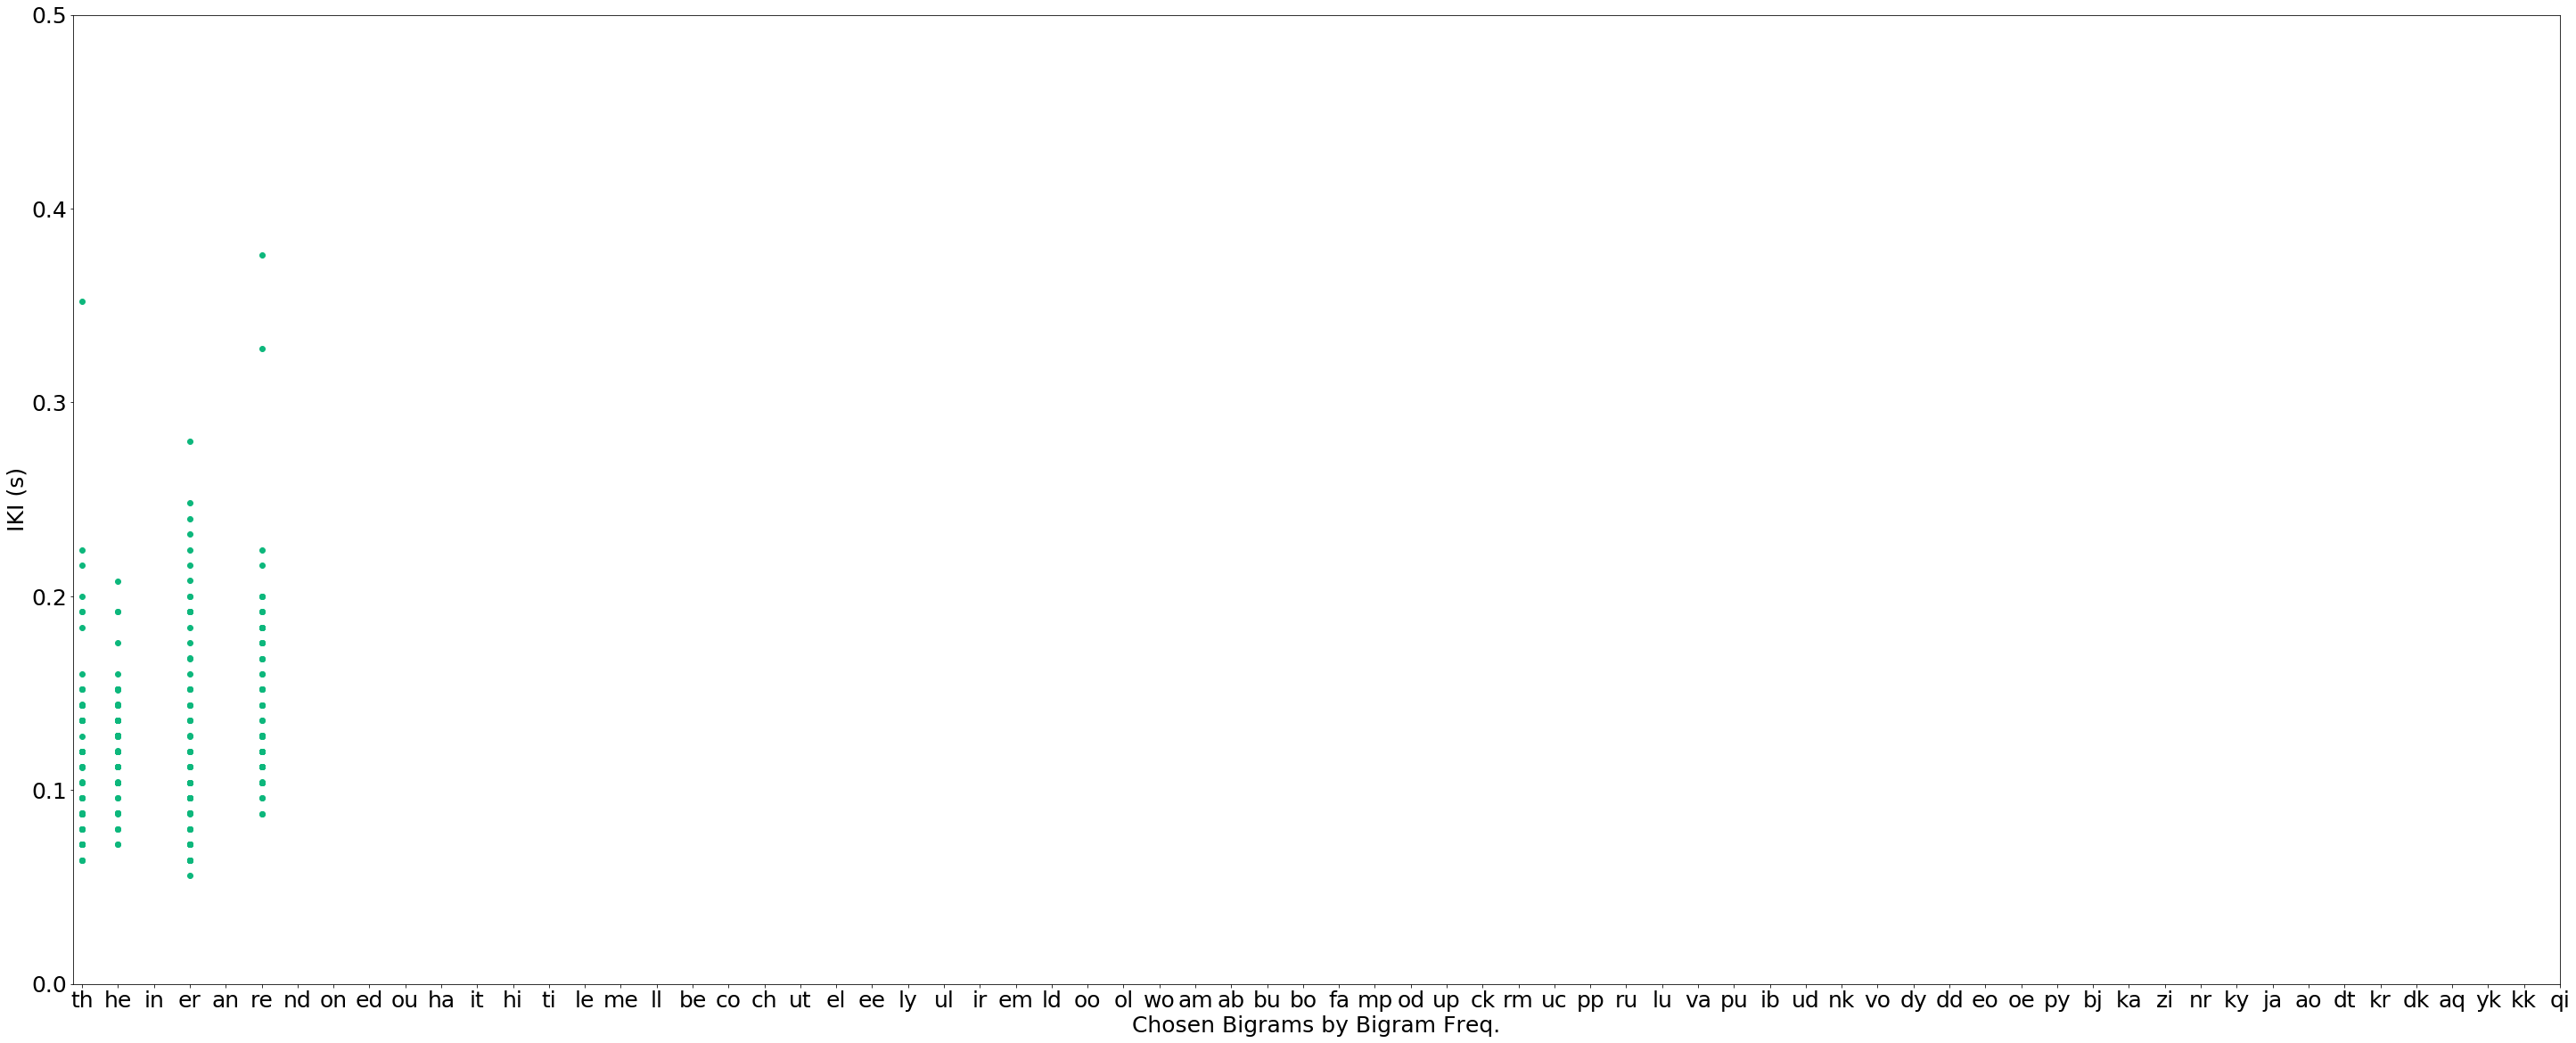

In [28]:
## scatter of iki values by bigram and word
plt.figure(figsize=(50, 20))

string = 'there'

s = bg_strings[bg_strings.isin([string])].stack()
L = s.index.tolist()
xvals = []
ikis = []
for i in L:
    xvals.append(bg_xvals.iloc[i])
    ikis.append(bg_ikis.iloc[i])
rbg = np.random.rand(3,).reshape(1,-1)
plt.scatter(xvals, ikis, c=rbg)

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# plt.legend(loc= "best")
plt.ylim([0, 0.5])
# plt.ylim([0.04775, 0.04825])

plt.show()

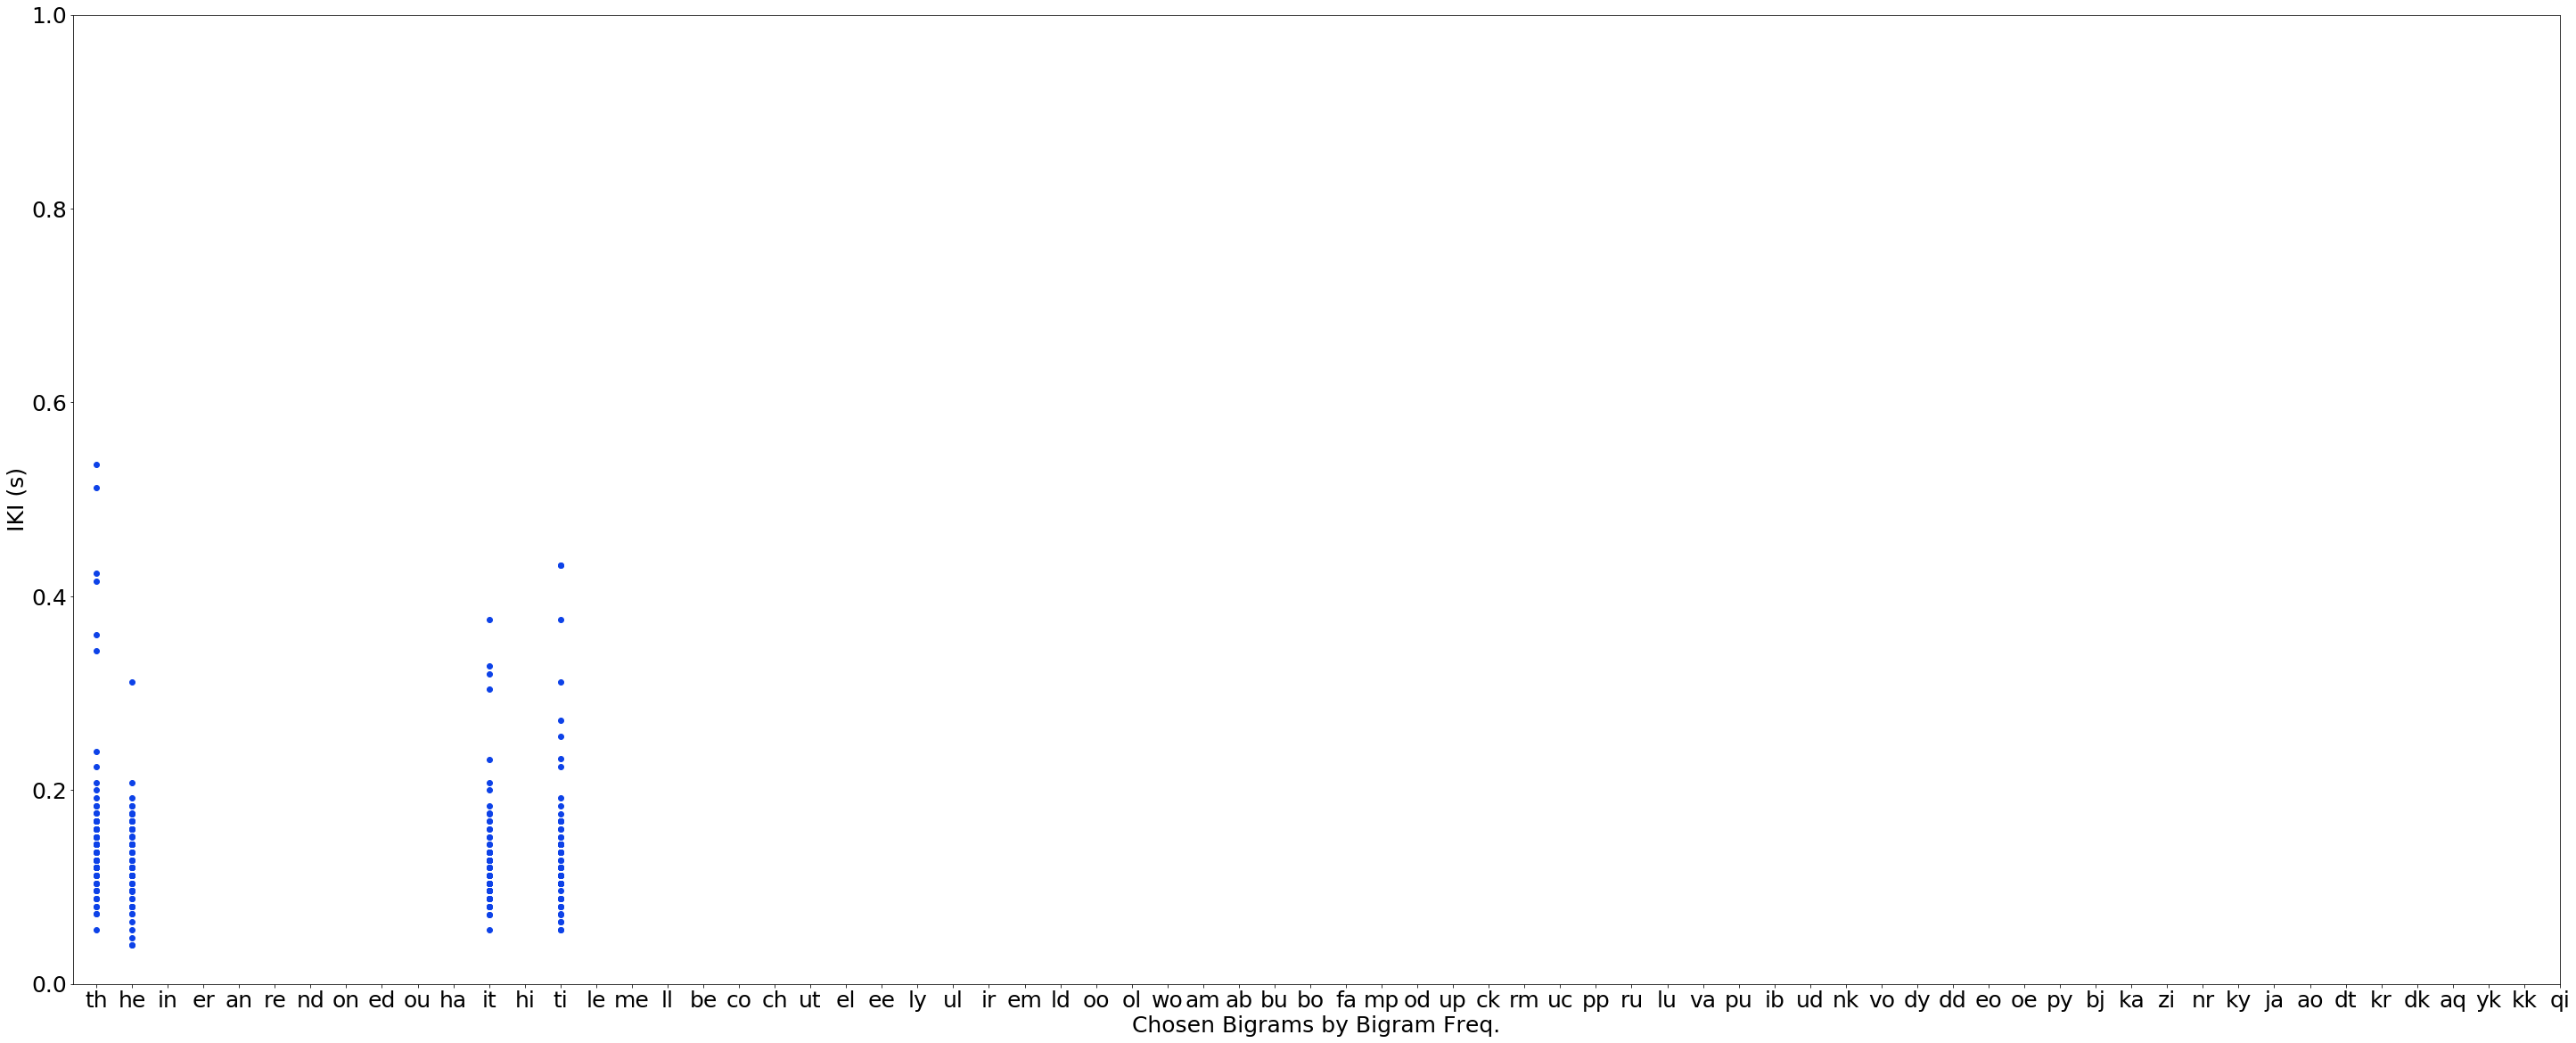

In [29]:
## scatter of iki values by bigram and word
plt.figure(figsize=(50, 20))

string = 'tithe'

s = bg_strings[bg_strings.isin([string])].stack()
L = s.index.tolist()
xvals = []
ikis = []
for i in L:
    xvals.append(bg_xvals.iloc[i])
    ikis.append(bg_ikis.iloc[i])
rbg = np.random.rand(3,).reshape(1,-1)
plt.scatter(xvals, ikis, c=rbg)

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

In [114]:
## defining functions that calculate individual IKI means and CVs for a particular bigram in a defined string
def indiv_means_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and Bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and Bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

# def indiv_error_bybg(string, bigram):
#     DF = incorr_bgs.query('string == @string and Bigram == @bigram')
#     errors = pd.DataFrame(DF.groupby('sID').resp_string.agg(['sum']))
#     return errors

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings
def indiv_means(str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = tight_bgs[tight_bgs.string.isin(sort_type)]
    else:
        DF = tight_bgs[tight_bgs.Bigram.isin(sort_type)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    means.columns = ['Avg IKI']
    return means

def indiv_avgcvs(str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = tight_bgs[tight_bgs.string.isin(sort_type)]
    else:
        DF = tight_bgs[tight_bgs.Bigram.isin(sort_type)]
    cvs = DF.groupby(['sID', 'string']).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean']))
    avg_cvs.columns = ['Avg CV IKI']
    return avg_cvs

In [119]:
indiv_error_bybg('there', 'th')
# indiv_cvs_bybg('there', 'th')
incorr_bgs[incorr_bgs['string'] == 'there']

sID  bigram_num  trial Bigram       IKI string resp_string  rep #
77    p09         657    162     th  0.040106  there      theref      5
78    p09         658    162     he  0.119898  there      theref      5
79    p09         659    162     er  0.216006  there      theref      5
80    p09         660    162     re  0.304059  there      theref      5
81    p09         661    162     ef  0.375944  there      theref      5
264  s178         507    126     th  0.096023  there      theree      5
265  s178         508    126     he  0.088002  there      theree      5
266  s178         509    126     er  0.127911  there      theree      5
267  s178         510    126     re  0.064011  there      theree      5
268  s178         511    126     ee  0.487986  there      theree      5
354  s179         649    162     he  0.432048  there        here      8
355  s179         650    162     er  0.119940  there        here      8
356  s179         651    162     re  0.128100  there        here      8
481  s175         676    167     th  0.079981  there      therre      8
482  s175         677    167     he  0.159967  there      therre      8
483  s175         678    167     er  0.136056  there      therre      8
484  s175         679    167     rr  0.135966  there      therre      8
485  s175         680    167     re  0.007973  there      therre      8
534   s83         351     87     th  0.103974  there        thre      3
535   s83         352     87     hr  0.120050  there        thre      3
536   s83         353     87     re  0.152017  there        thre      3
637   s20         362     90     th  0.103955  there        ther      3
638   s20         363     90     he  0.112069  there        ther      3
639   s20         364     90     er  0.071919  there        ther      3

In [31]:
# def indiv_means_strtype(str_type):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.string.isin(str_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'Words/Bigrams Used':str_type, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_strtype(str_type):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.string.isin(str_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'Words/Bigrams Used':str_type, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

# def indiv_means_bgtype(bg_type):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.Bigram.isin(bg_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'Words/Bigrams Used':bg_type, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_bgtype(bg_type):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.Bigram.isin(bg_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'Words/Bigrams Used':bg_type, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

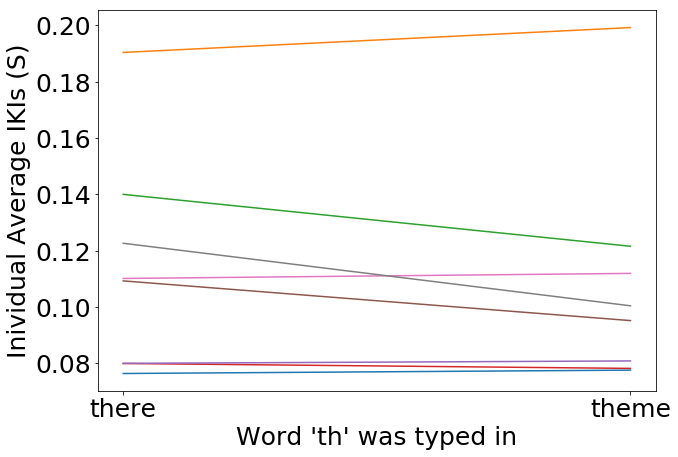

In [32]:
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

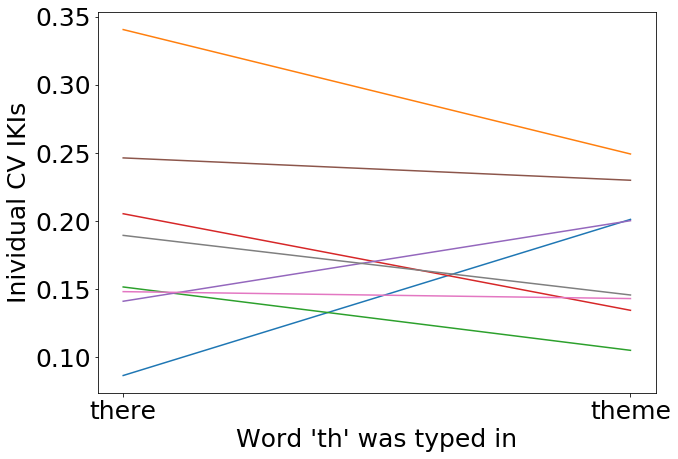

In [33]:
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

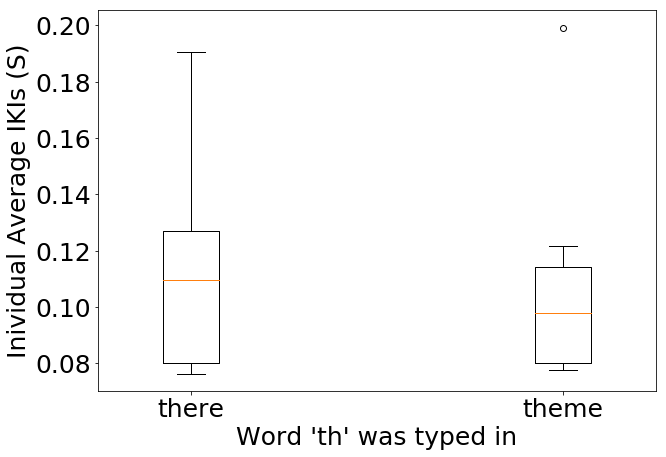

In [34]:
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

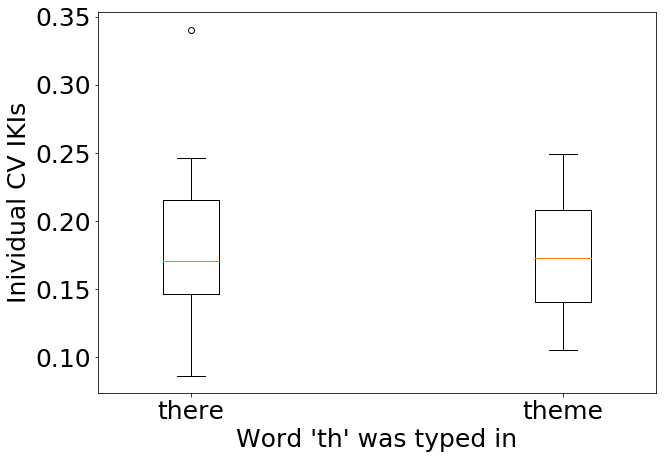

In [35]:
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

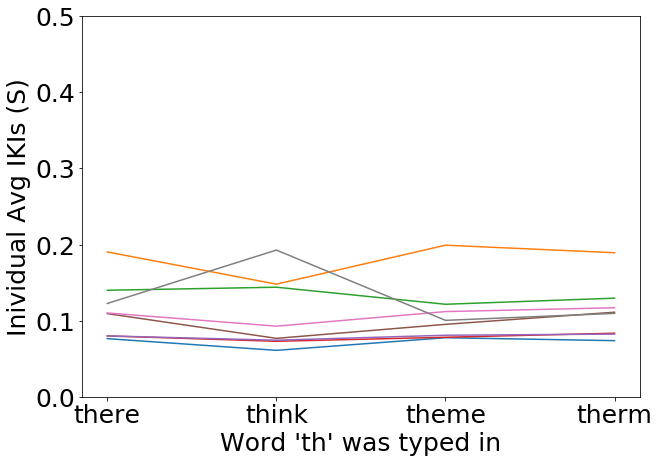

In [36]:
x = [2, 4, 6, 8]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('think', 'th')['mean'], 
     indiv_means_bybg('theme', 'th')['mean'], indiv_means_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

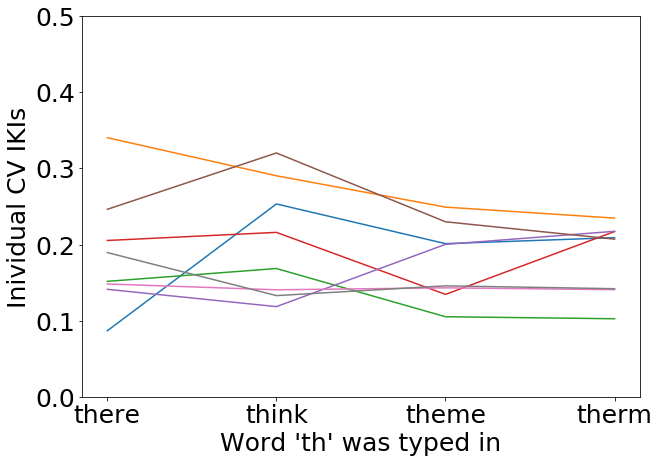

In [37]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

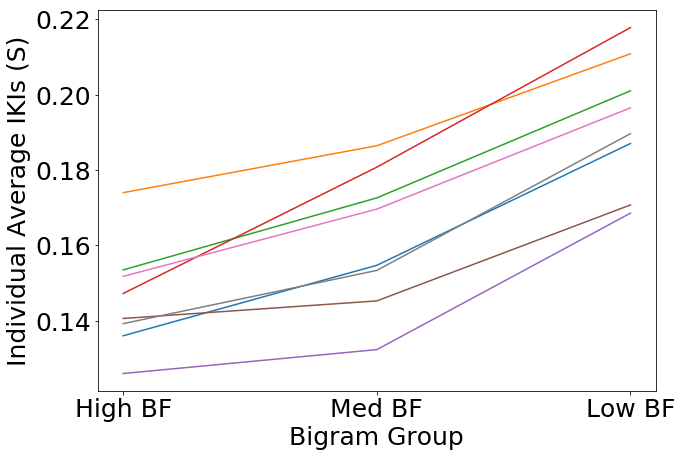

In [38]:
## using bigrams from words in the corresponding bf category
x = [2, 4, 6]
D = (indiv_means('string', typ.highbf)['Avg IKI'], indiv_means('string', typ.medbf)['Avg IKI'], 
     indiv_means('string', typ.lowbf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Group")
plt.ylabel("Individual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

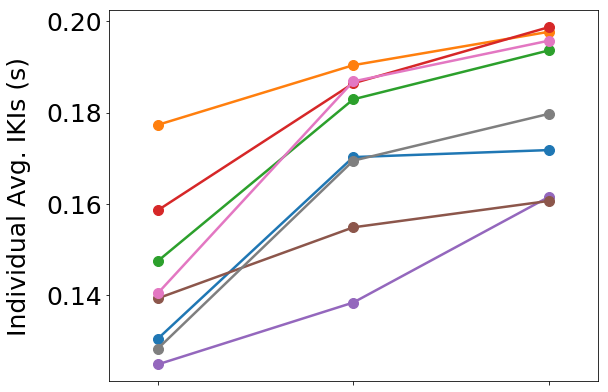

In [39]:
## using bigrams sorted by bf
x = [2, 4, 6]
D = (indiv_means('bigram', high_bgs['Bigrams'])['Avg IKI'], indiv_means('bigram', med_bgs['Bigrams'])['Avg IKI'], 
     indiv_means('bigram', low_bgs['Bigrams'])['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xticks(x, ('', '', ''))
# plt.xlabel("Bigram Group")
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)
plt.xlim([1.5, 6.5])
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

fig.tight_layout()
plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

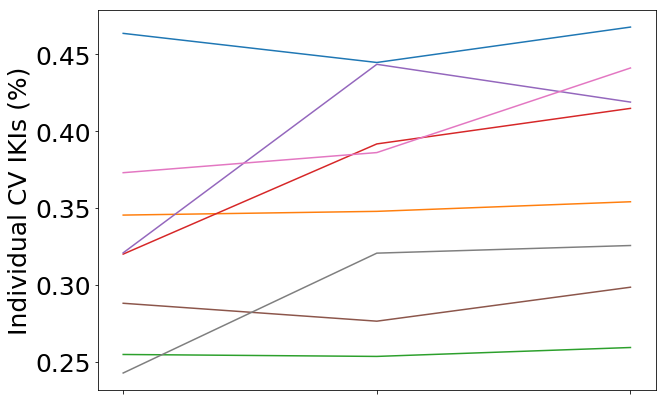

In [40]:
# using bigrams from words in the corresponding bf category
x = [2, 4, 6]
D = (indiv_avgcvs('string', typ.highbf)['Avg CV IKI'], indiv_avgcvs('string', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs('string', typ.lowbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('', '', ''))
# plt.xlabel("Bigram Group")
plt.ylabel("Individual CV IKIs (%)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

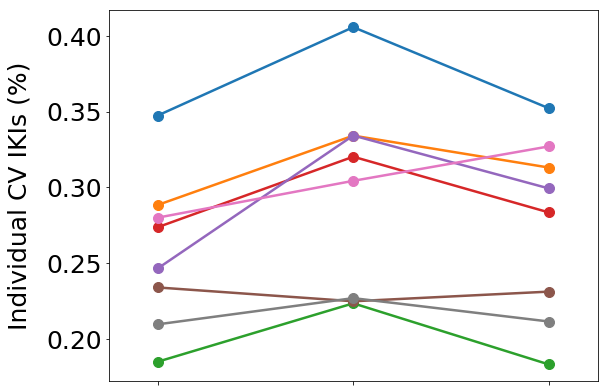

In [41]:
## using bigrams sorted by bf
x = [2, 4, 6]
D = (indiv_avgcvs('bigram', high_bgs['Bigrams'])['Avg CV IKI'], indiv_avgcvs('bigram', med_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs('bigram', low_bgs['Bigrams'])['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xticks(x, ('', '', ''))
# plt.xlabel("Bigram Group")
plt.ylabel("Individual CV IKIs (%)", labelpad=15)
# plt.ylim([0, 0.8])
plt.xlim([1.5, 6.5])
plt.title("")
# plt.legend(loc="best")

fig.tight_layout()
plt.savefig('indiv_cv_ikis.png', dpi=300)
plt.show()

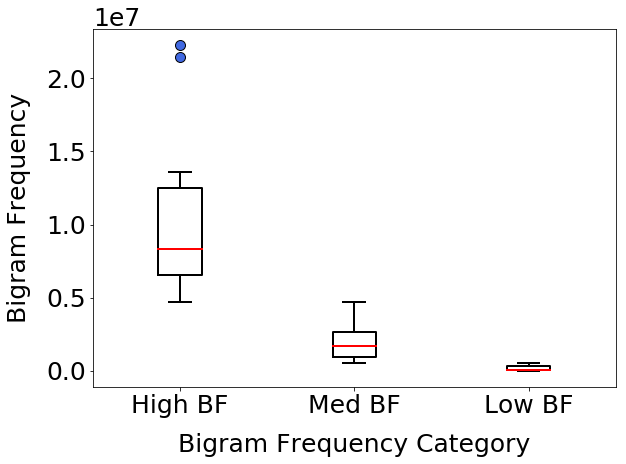

In [42]:
x = [2, 4, 6]
D = (high_bgs['Frequency'], med_bgs['Frequency'], low_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2)
whiskerprops = dict(linewidth=2)
capprops = dict(linewidth=2)
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Bigram Frequency", labelpad=15)
plt.xlim([1, 7])

# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

fig.tight_layout()
plt.savefig('wf.png', dpi=300)
plt.show()

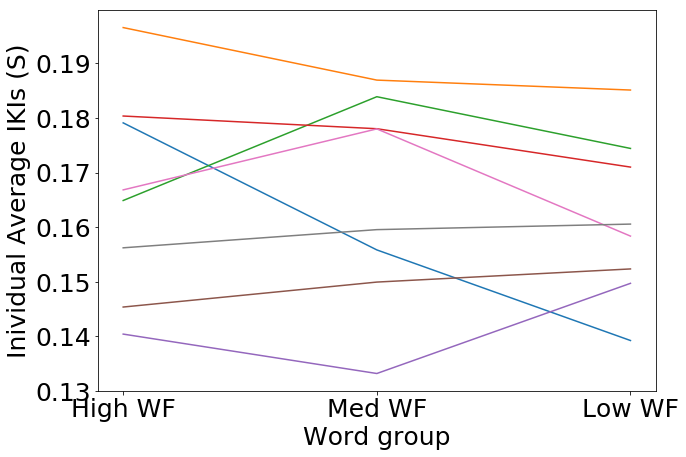

In [43]:
x = [2, 4, 6]
D = (indiv_means('string', typ.highwf)['Avg IKI'], indiv_means('string', typ.medwf)['Avg IKI'], 
     indiv_means('string', typ.lowwf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('High WF', 'Med WF', 'Low WF'))
plt.xlabel("Word group")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

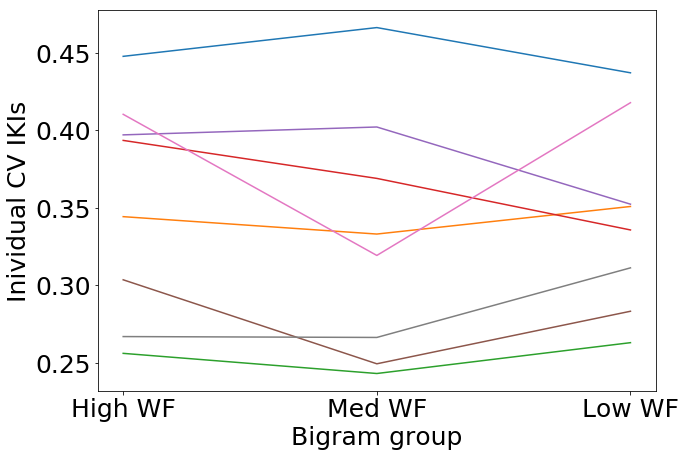

In [44]:
x = [2, 4, 6]
D = (indiv_avgcvs('string', typ.highwf)['Avg CV IKI'], indiv_avgcvs('string', typ.medwf)['Avg CV IKI'], 
     indiv_avgcvs('string', typ.lowwf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('High WF', 'Med WF', 'Low WF'))
plt.xlabel("Bigram group")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [55]:
## plotting error rates by word freq group
incorr_bgs

## defining function to calculate individual error rates for each bigram

sID  bigram_num  trial Bigram       IKI string resp_string  rep #
0    p09          12      3     kt  0.120063  kremp      ktremp      0
1    p09          13      3     tr  0.455932  kremp      ktremp      0
2    p09          14      3     re  0.192022  kremp      ktremp      0
3    p09          15      3     em  0.256028  kremp      ktremp      0
4    p09          16      3     mp  0.304023  kremp      ktremp      0
..   ...         ...    ...    ...       ...    ...         ...    ...
718  s20         931    232     em  0.047948  theme       theem      9
719  s20         940    235     ch  0.128069  champ       chamo      9
720  s20         941    235     ha  0.175927  champ       chamo      9
721  s20         942    235     am  0.168062  champ       chamo      9
722  s20         943    235     mo  0.151994  champ       chamo      9

[723 rows x 8 columns]

In [56]:
def delta_iki(bigram, string):
    all_deltas = []
    for sub in ID_list:
        sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.Bigram == bigram) & (tight_bgs.string == string)]
        deltas = [sub]
        for trial in range(0, len(sub_df) - 1):
            deltas.append(sub_df.iloc[trial + 1, 4] - sub_df.iloc[trial, 4]) ## depends on column position
        all_deltas.append(deltas)
    all_deltas = pd.DataFrame(all_deltas)
    all_deltas = all_deltas.transpose()
    return all_deltas

In [46]:
def iki_change_bysub(bigram, string):
    all_subs = pd.DataFrame()
    for sub in ID_list:
        sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.Bigram == bigram) & (tight_bgs.string == string)]
        ikis = sub_df['IKI'].tolist()
        while len(ikis) != 10:
            ikis.append(np.nan)
        all_subs[sub] = ikis
    return all_subs
        
iki_change_bysub('pu', 'puppy')

s83       s20      s179      s178      s175       p09       p10  \
0  0.231904  0.408087  0.120019  0.224006  0.343962  0.200013  0.303950   
1  0.215963  0.248033  0.104102  0.200019  0.327963  0.271999  0.359925   
2  0.223882  0.255958  0.135959  0.232031  0.376076  0.200040  0.288002   
3  0.351879  0.191992  0.135991  0.232091  0.288030  0.247990  0.336026   
4  0.231981  0.303972  0.143982  0.231961  0.296061  0.272028  0.271949   
5  0.184043  0.304059  0.120058  0.247928  0.288034  0.232025  0.295986   
6  0.224068       NaN  0.136023  0.248023       NaN  0.255976  0.319957   
7  0.352076       NaN       NaN  0.200118       NaN  0.264014       NaN   
8  0.191886       NaN       NaN  0.215977       NaN  0.239969       NaN   
9  0.144011       NaN       NaN  0.320057       NaN  0.264035       NaN   

        p11  
0  0.311850  
1  0.327953  
2  0.287961  
3  0.295970  
4  0.288002  
5  0.255932  
6  0.312056  
7  0.247907  
8  0.288010  
9       NaN

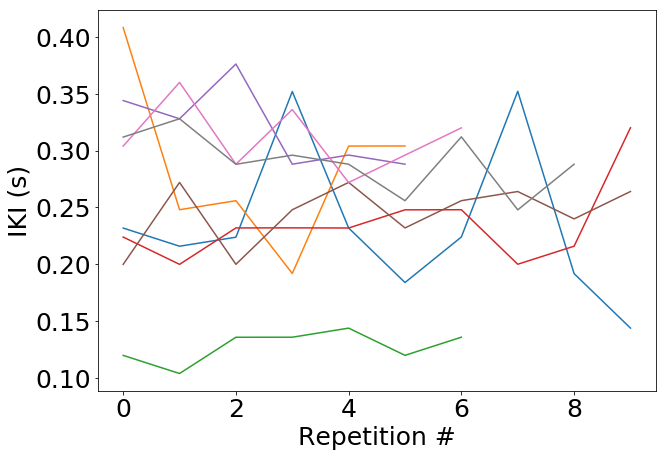

In [47]:
##plotting IKI accross repetitions for each individual

df = iki_change_bysub('pu', 'puppy')

df.plot(figsize=(10, 7))

# plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
plt.xlabel("Repetition #")
plt.ylabel("IKI (s)")
# plt.ylim([0, 0.8])
plt.title("")
plt.legend().remove()

plt.show()

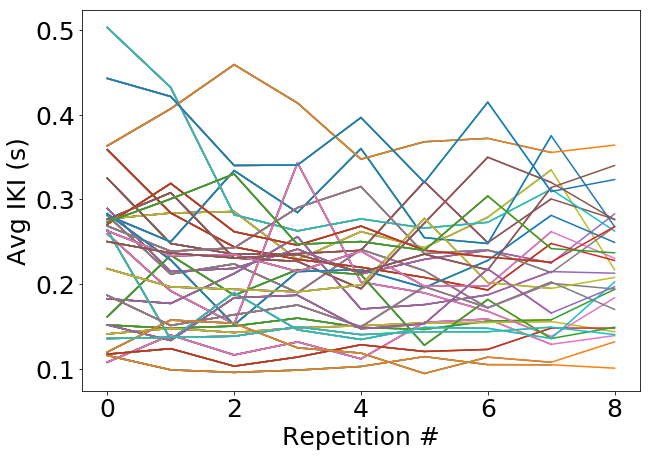

In [48]:
## plotting average IKI for a particular bigram in a particular word across repetitions (for correct trials only)

plt.figure(figsize=(10, 7))
for bg in typ.lowbf_bgs:
    by_bg = corr_bgs[corr_bgs.Bigram == bg]
    rep_ikis = []
    for n in range(0, 9):
        all_reps = by_bg[by_bg['rep #'] == n]
        avg_iki_byrep = all_reps['IKI'].mean()
        rep_ikis.append(avg_iki_byrep)

        plt.plot(rep_ikis)

        # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
        plt.xlabel("Repetition #")
        plt.ylabel("Avg IKI (s)")
        # plt.ylim([0, 0.8])
        plt.title("")
        # plt.legend().remove()

plt.show()

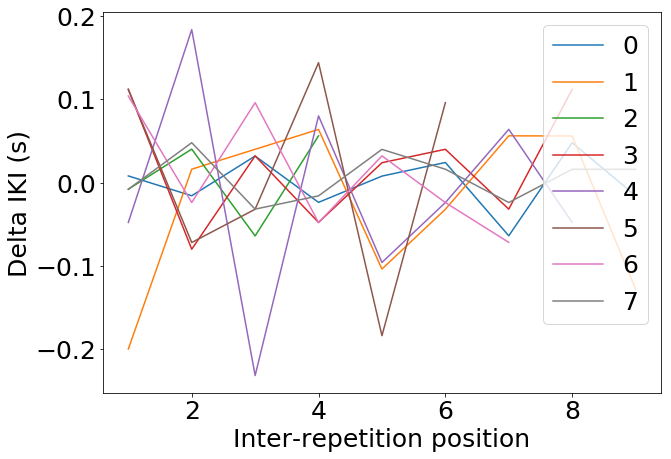

In [49]:
yk_df = delta_iki('dk', 'vodka')[1:]

yk_df.plot(figsize=(10, 7))

# plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
plt.xlabel("Inter-repetition position")
plt.ylabel("Delta IKI (s)")
# plt.ylim([0, 0.8])
plt.title("")
plt.legend(loc="best")

plt.show()

In [50]:
def indiv_means_bgonly(bigram):
    means = pd.DataFrame()
    DF = tight_bgs[tight_bgs['Bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        means = means.append({'ID':sID, 'Bigram':bigram, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
    return means

def indiv_cvs_bgonly(bigram):
    cvs = pd.DataFrame()
    DF = tight_bgs[tight_bgs['Bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        cvs = cvs.append({'ID':sID, 'Bigram':bigram, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
    return cvs

In [51]:
all_indiv_means = pd.DataFrame()
for bigram in bg_freqs['Bigrams']:
    all_indiv_means = all_indiv_means.append(indiv_means_bgonly(bigram), ignore_index=True).dropna(axis = 0)

all_indiv_cvs = pd.DataFrame()
for bigram in bg_freqs['Bigrams']:
    all_indiv_cvs = all_indiv_cvs.append(indiv_cvs_bgonly(bigram), ignore_index=True).dropna(axis = 0)

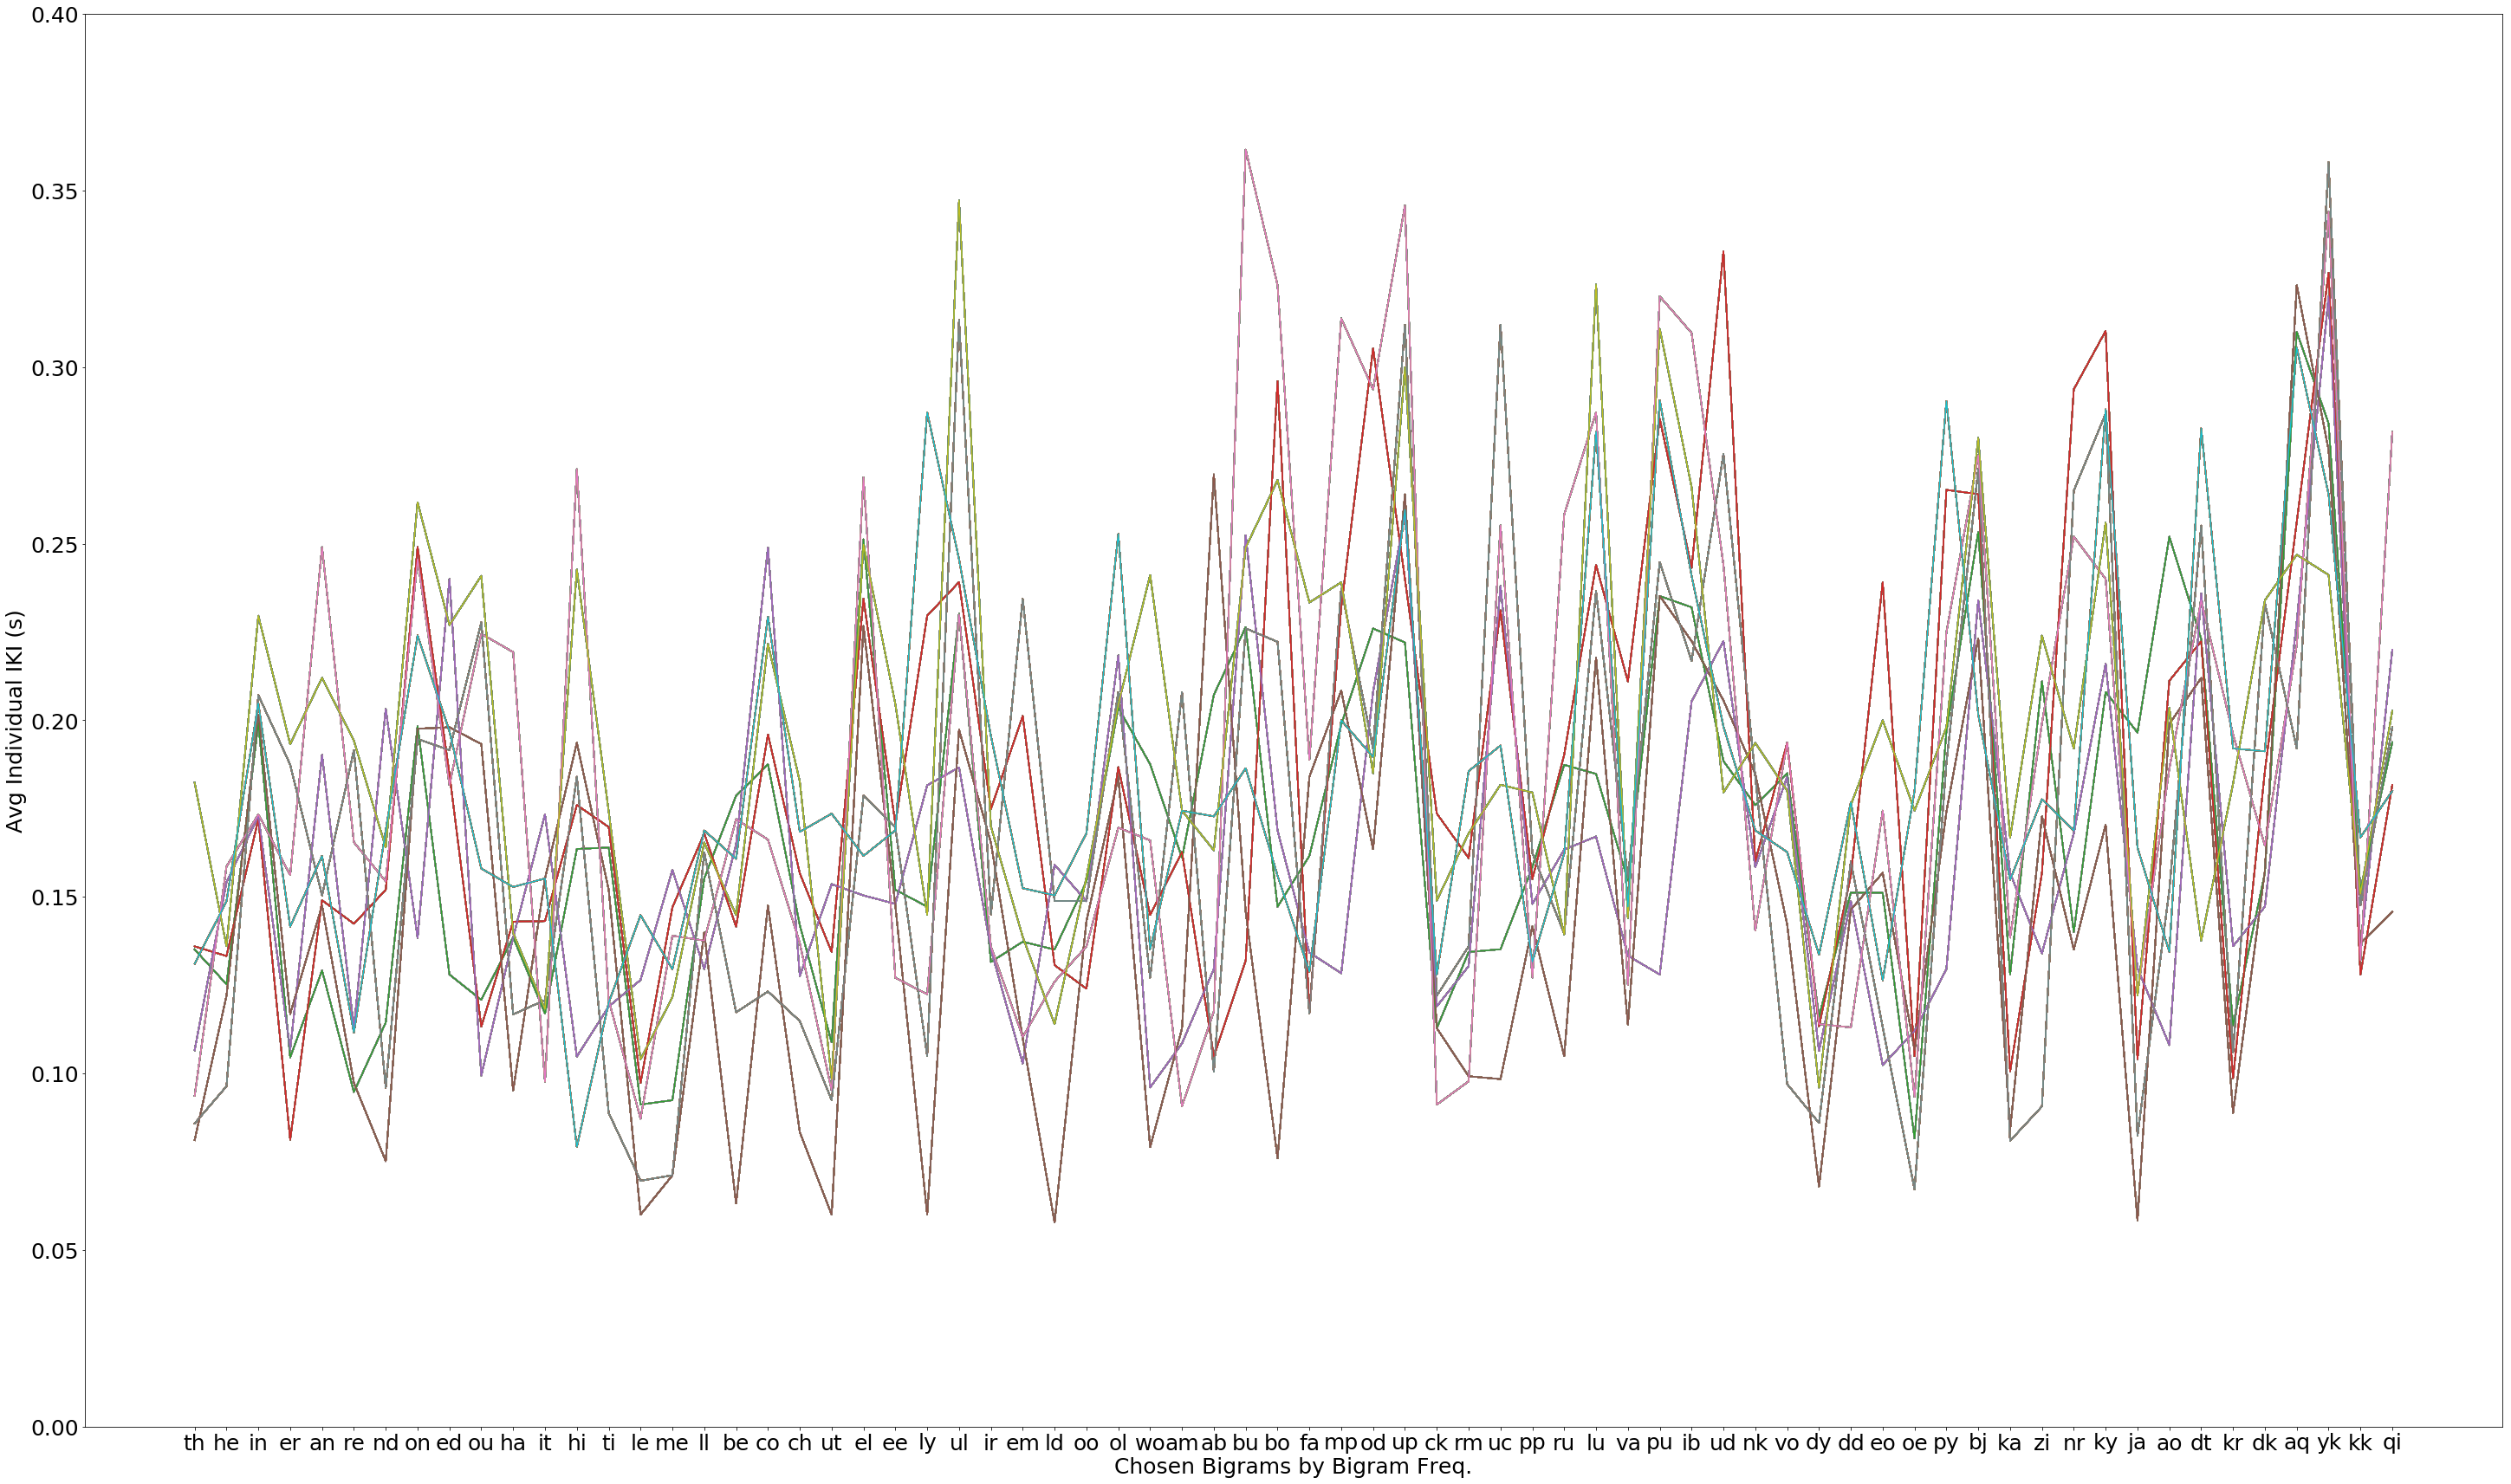

In [52]:
## plot of individual avg iki values by bigram

fig, ax = plt.subplots(figsize=(50, 30))

for bigram in bg_freqs['Bigrams']:
    for sub in ID_list:
        bg_df = all_indiv_means[all_indiv_means.ID == sub]
    # bg_df = all_indiv_means[all_indiv_means.ID == 83]
        ax.plot(bg_df['Bigram'], bg_df['Avg IKI'])

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("Avg Individual IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_df['Bigram'])
# plt.legend(loc= "best")
plt.ylim([0, 0.4])
# plt.ylim([0.04775, 0.04825])

plt.show()

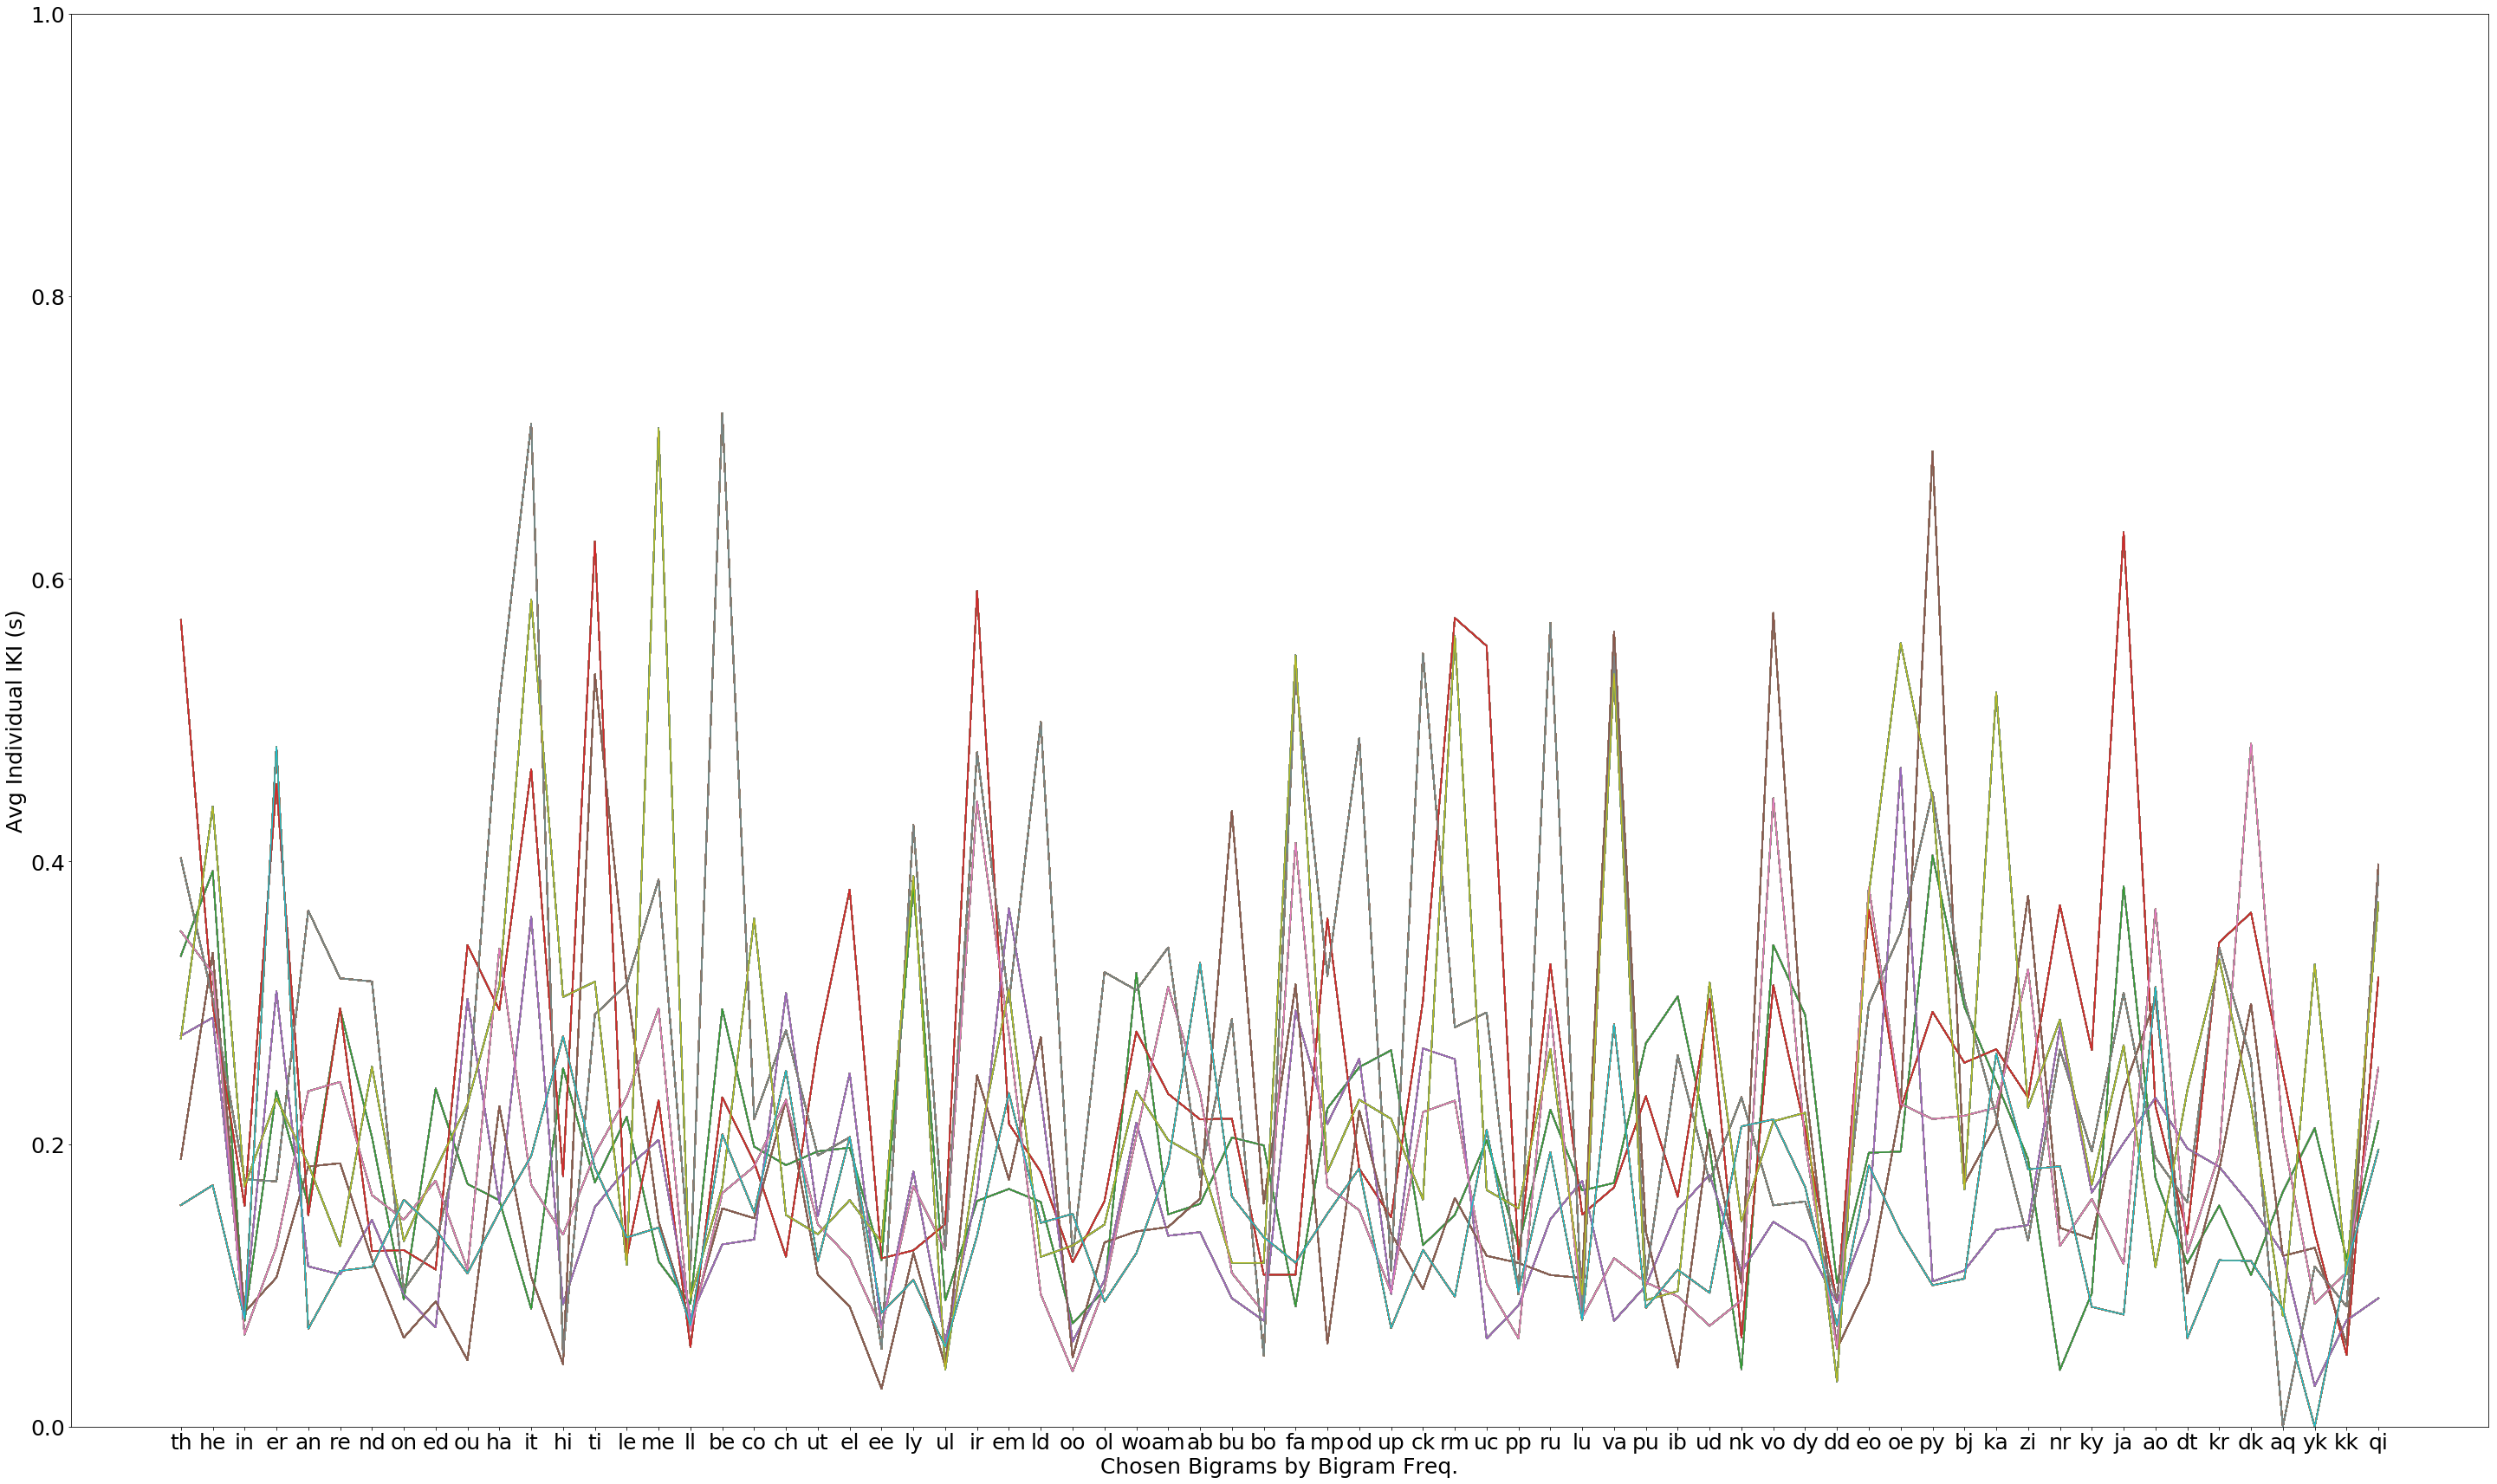

In [53]:
## plot of individual cv iki values by bigram

fig, ax = plt.subplots(figsize=(50, 30))

for bigram in bg_freqs['Bigrams']:
    for sub in ID_list:
        bg_df = all_indiv_cvs[all_indiv_cvs.ID == sub]
    # bg_df = all_indiv_means[all_indiv_means.ID == 83]
        ax.plot(bg_df['Bigram'], bg_df['CV IKI'])

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("Avg Individual IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_df['Bigram'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

In [54]:
th_means = pd.concat([indiv_means('there', 'th'), indiv_means('think', 'th'), indiv_means('theme', 'th'), indiv_means('therm', 'th')]
                     , ignore_index=True)

print(AnovaRM(data=th_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [str]

In [ ]:
th_cvs = pd.concat([indiv_cvs('there', 'th'), indiv_cvs('think', 'th'), indiv_cvs('theme', 'th'), indiv_cvs('therm', 'th')]
                     , ignore_index=True)

print(AnovaRM(data=th_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [ ]:
th_position_means = pd.concat([indiv_means('therm', 'th'), indiv_means('tithe', 'th')], ignore_index=True)

print(AnovaRM(data=th_position_means, depvar='Avg IKI', subject='ID', within=['String']).fit()) 

In [ ]:
th_position_cvs = pd.concat([indiv_cvs('therm', 'th'), indiv_cvs('tithe', 'th')], ignore_index=True)

print(AnovaRM(data=th_position_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [ ]:
th_wf_means = pd.concat([indiv_means('tithe', 'th'), indiv_means('edthe', 'th')], ignore_index=True)

print(AnovaRM(data=th_wf_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [ ]:
th_wf_cvs = pd.concat([indiv_cvs('tithe', 'th'), indiv_cvs('edthe', 'th')], ignore_index=True)

print(AnovaRM(data=th_wf_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())